In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif

from sklearn.linear_model import LogisticRegression

from matplotlib_venn import venn2
from tqdm import tqdm


In [4]:
# import custom functions
from src.functions import plot_correlations, plot_mutual_info, hello

In [2]:
data = pd.read_csv("./data/AIDS_Classification.csv")
data.head(1)

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0


## Settings

In [26]:
# default plt figuresize, smallish
plt.rcParams["figure.figsize"] = (6,3)

# Sprint 1

### 006 Dataset Structure

In [3]:
## number of rows and columns of the tabular data 
data.shape

(2139, 23)

In [4]:
## all data is integer except `wtkg`
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      2139 non-null   int64  
 1   trt       2139 non-null   int64  
 2   age       2139 non-null   int64  
 3   wtkg      2139 non-null   float64
 4   hemo      2139 non-null   int64  
 5   homo      2139 non-null   int64  
 6   drugs     2139 non-null   int64  
 7   karnof    2139 non-null   int64  
 8   oprior    2139 non-null   int64  
 9   z30       2139 non-null   int64  
 10  preanti   2139 non-null   int64  
 11  race      2139 non-null   int64  
 12  gender    2139 non-null   int64  
 13  str2      2139 non-null   int64  
 14  strat     2139 non-null   int64  
 15  symptom   2139 non-null   int64  
 16  treat     2139 non-null   int64  
 17  offtrt    2139 non-null   int64  
 18  cd40      2139 non-null   int64  
 19  cd420     2139 non-null   int64  
 20  cd80      2139 non-null   int6

### 007 Missing values


In [5]:
#there is no missing value
missing = pd.DataFrame({
    "null": data.isnull().sum(), 
    "NaN": data.isna().sum()
})
missing

,null,NaN
time,0,0
trt,0,0
age,0,0
wtkg,0,0
hemo,0,0
homo,0,0
drugs,0,0
karnof,0,0
oprior,0,0
z30,0,0


### 008 Target is binary 

In [7]:
# The target variable 'infected' is binary with values 0 and 1
data['infected'].unique()

array([0, 1])

### 009 Class imbalance 
<a id='009'></a>


infected
0    1618
1     521
Name: count, dtype: int64
Proportion of infected: 24.36%


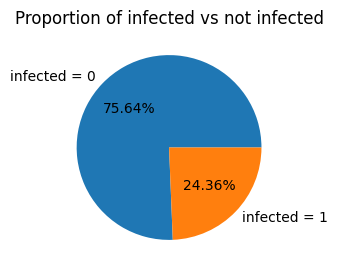

In [11]:
# The target class is moderately imbalanced : the positive class "infected" has the least numerosity 
count_infected_df = data['infected'].value_counts()
proportion_infected = count_infected_df[1]/(count_infected_df.sum())
print(count_infected_df)
print(f"Proportion of infected: {round(proportion_infected*100,2)}%")

plt.pie(count_infected_df, 
        labels = ["infected = 0", "infected = 1"], 
        colors = sns.color_palette(), 
        autopct='%.2f%%')
plt.title("Proportion of infected vs not infected")
plt.show()


### 010 Missing values strategy


There are no missing values in the dataset

#### 010 - the case of zero cd40 

We saw that there are no Null values in the data. However, for numerical features, missing values may have been recordeds as "zeros". There are 9 numerical features, two multiclass categorical features and 12 binary features (including the target). 

In [8]:
continuous_variables = "time age wtkg karnof preanti cd40 cd420 cd80 cd820".split()
data[continuous_variables].describe()

,time,age,wtkg,karnof,preanti,cd40,cd420,cd80,cd820
count,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000
mean,879.098177,35.248247,75.125311,95.446470,379.175783,350.501169,371.307153,986.627396,935.369799
std,292.274324,8.709026,13.263164,5.900985,468.657526,118.573863,144.634909,480.197750,444.976051
min,14.000000,12.000000,31.000000,70.000000,0.000000,0.000000,49.000000,40.000000,124.000000
25%,727.000000,29.000000,66.679200,90.000000,0.000000,263.500000,269.000000,654.000000,631.500000
50%,997.000000,34.000000,74.390400,100.000000,142.000000,340.000000,353.000000,893.000000,865.000000
75%,1091.000000,40.000000,82.555200,100.000000,739.500000,423.000000,460.000000,1207.000000,1146.500000
max,1231.000000,70.000000,159.939360,100.000000,2851.000000,1199.000000,1119.000000,5011.000000,6035.000000


The  minimum value for 'preanti' is 0, but this is normal, since it corresponds to the patients that started antiretroviral treatment contextually with this study. The minimum value for `cd40' may actually be 0, although this is unlikely since it is the number of cd4 cells per mm3 blood, and the average in the dataset is 350. Some inspection is required. 

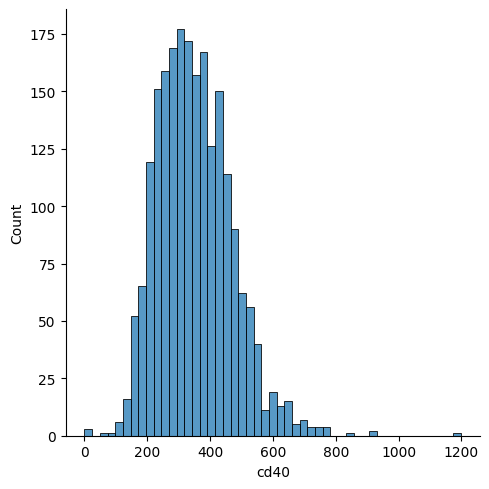

In [9]:
sns.displot(data= data, x= 'cd40')

In [10]:
data_zero_cd40 = data[data['cd40']==0]
data_zero_cd40

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
216,1027,1,45,67.1000,0,1,0,100,0,1,...,1,3,0,1,0,0,359,468,659,0
217,985,1,60,51.6000,0,0,0,100,0,1,...,1,3,0,1,1,0,523,1087,1727,0
723,1124,1,30,81.1944,0,1,1,100,0,0,...,0,1,0,1,1,0,566,998,1078,0


There are three patients with zero cd4 count. 

In [11]:
data[data['cd40']<120]

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
216,1027,1,45,67.1000,0,1,0,100,0,1,...,1,3,0,1,0,0,359,468,659,0
217,985,1,60,51.6000,0,0,0,100,0,1,...,1,3,0,1,1,0,523,1087,1727,0
285,1089,1,48,91.1736,0,1,0,100,0,1,...,1,3,0,1,0,84,541,706,1516,0
358,1022,0,34,79.6000,0,1,0,100,0,0,...,0,1,1,0,1,103,237,1084,1313,0
723,1124,1,30,81.1944,0,1,1,100,0,0,...,0,1,0,1,1,0,566,998,1078,0
1455,1029,1,43,101.0000,0,1,0,100,0,0,...,1,2,0,1,1,70,197,314,893,0
1667,1001,2,41,65.0916,1,0,0,100,1,0,...,1,3,0,1,1,99,80,105,173,0
1920,904,3,33,75.5000,0,1,0,90,0,0,...,0,1,0,1,1,112,348,291,541,1
1993,885,3,47,62.5968,0,0,0,90,0,1,...,1,3,0,1,1,110,80,230,140,1


Comparing with "low cd40" patients, we do not find enough evidence to infer that the null cd40 is to be treated as a "missing" value. We will consider this in the "outlier" analysis though.  

### 011 Numerical distributions

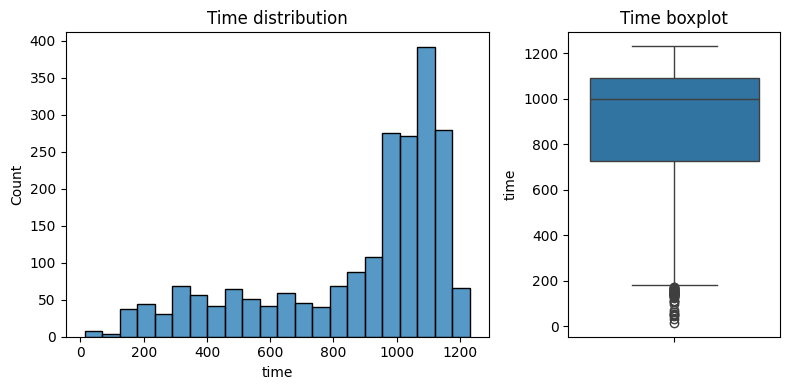

In [12]:

feature = "time"
fig,axes = plt.subplots(1,2,figsize = (8,4), sharey = False, gridspec_kw={'width_ratios': [2, 1]})
sns.histplot(data = data, x = feature, ax = axes[0])
sns.boxplot(data = data, y = feature, ax = axes[1])
axes[0].set_title(f'{feature.capitalize()} distribution')
axes[1].set_title(f'{feature.capitalize()} boxplot')
plt.tight_layout()
plt.show()

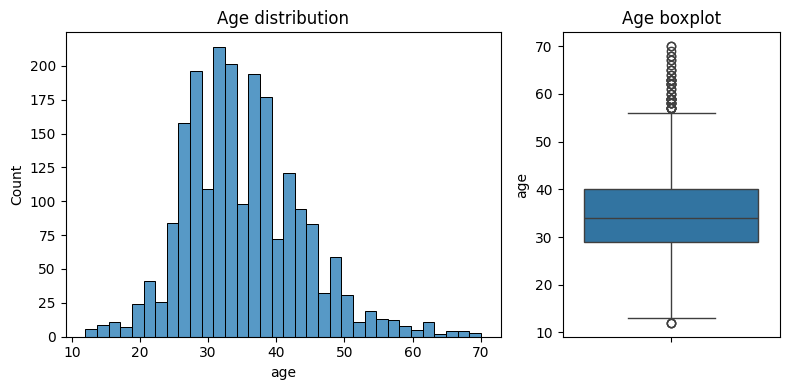

In [13]:
feature = "age"
fig,axes = plt.subplots(1,2,figsize = (8,4), sharey = False, gridspec_kw={'width_ratios': [2, 1]})
sns.histplot(data = data, x = feature, ax = axes[0])
sns.boxplot(data = data, y = feature, ax = axes[1])
axes[0].set_title(f'{feature.capitalize()} distribution')
axes[1].set_title(f'{feature.capitalize()} boxplot')
plt.tight_layout()
plt.show()

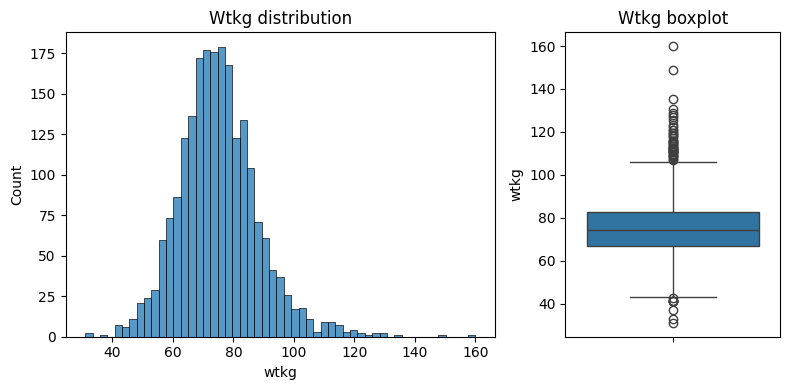

In [15]:
feature = "wtkg"
fig,axes = plt.subplots(1,2,figsize = (8,4), sharey = False, gridspec_kw={'width_ratios': [2, 1]})
sns.histplot(data = data, x = feature, ax = axes[0])
sns.boxplot(data = data, y = feature, ax = axes[1])
axes[0].set_title(f'{feature.capitalize()} distribution')
axes[1].set_title(f'{feature.capitalize()} boxplot')
plt.tight_layout()
plt.show()

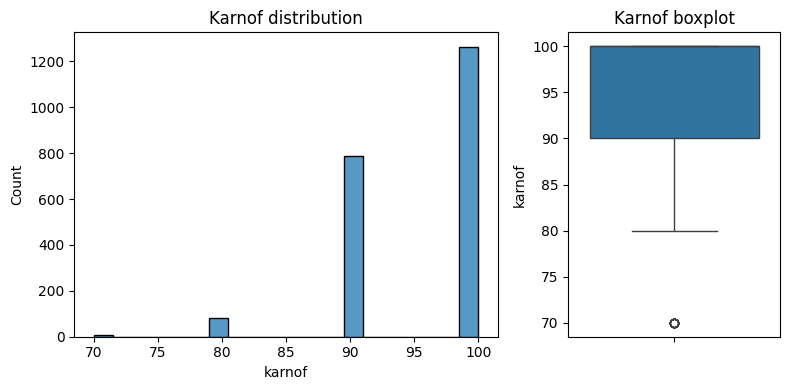

In [16]:
feature = "karnof"
fig,axes = plt.subplots(1,2,figsize = (8,4), sharey = False, gridspec_kw={'width_ratios': [2, 1]})
sns.histplot(data = data, x = feature, ax = axes[0])
sns.boxplot(data = data, y = feature, ax = axes[1])
axes[0].set_title(f'{feature.capitalize()} distribution')
axes[1].set_title(f'{feature.capitalize()} boxplot')
plt.tight_layout()
plt.show()

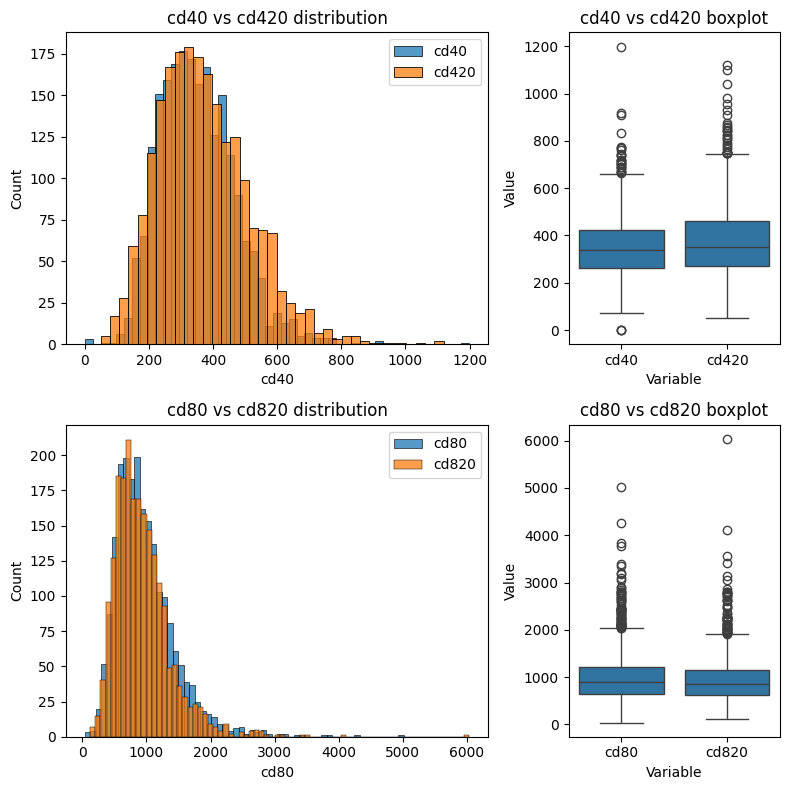

In [ ]:
long_data_1 = pd.melt(data[['cd40', 'cd420']], var_name='Variable', value_name='Value')
long_data_2 = pd.melt(data[['cd80', 'cd820']], var_name='Variable', value_name='Value')
fig,axes = plt.subplots(2,2,figsize = (8,8), sharey = False, gridspec_kw={'width_ratios': [2, 1]})
sns.histplot(data = data, x = "cd40",label="cd40", ax = axes[0,0])
sns.histplot(data=data,x="cd420",label="cd420",ax=axes[0,0])
sns.histplot(data = data, x = "cd80",label="cd80", ax = axes[1,0])
sns.histplot(data=data,x="cd820",label="cd820",ax=axes[1,0])
sns.boxplot(data=long_data_1, x='Variable', y='Value', ax=axes[0, 1])
sns.boxplot(data=long_data_2, x='Variable', y='Value', ax=axes[1, 1])
axes[0, 0].set_title('cd40 vs cd420 distribution')
axes[1, 0].set_title('cd80 vs cd820 distribution')
axes[0, 1].set_title('cd40 vs cd420 boxplot')
axes[1,1].set_title("cd80 vs cd820 boxplot")
axes[0,0].legend()
axes[1,0].legend()
plt.tight_layout()
plt.show()

### 012 Categorical frequencies

trt: treatment indicator (0 = ZDV only; 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only)


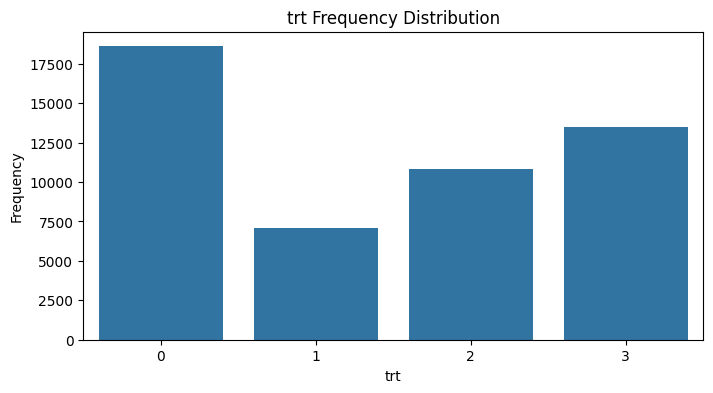

trt
0    18592
3    13513
2    10806
1     7089
Name: count, dtype: int64


In [58]:
print("\033[1mtrt: treatment indicator (0 = ZDV only; 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only)\033[0m")
frequency = data['trt'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='trt', data=data)
plt.title('trt Frequency Distribution')
plt.xlabel('trt')
plt.ylabel('Frequency')
plt.show()
print(frequency)

hemo: hemophilia (0=no, 1=yes)m


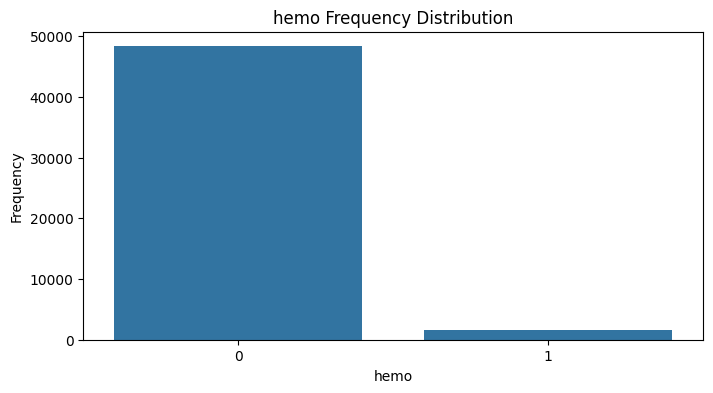

hemo
0    48326
1     1674
Name: count, dtype: int64


In [59]:
print("\033[1mhemo: hemophilia (0=no, 1=yes)\033[om")
frequency = data['hemo'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='hemo', data=data)
plt.title('hemo Frequency Distribution')
plt.xlabel('hemo')
plt.ylabel('Frequency')
plt.show()
print(frequency)

homo: homosexual activity (0=no, 1=yes)


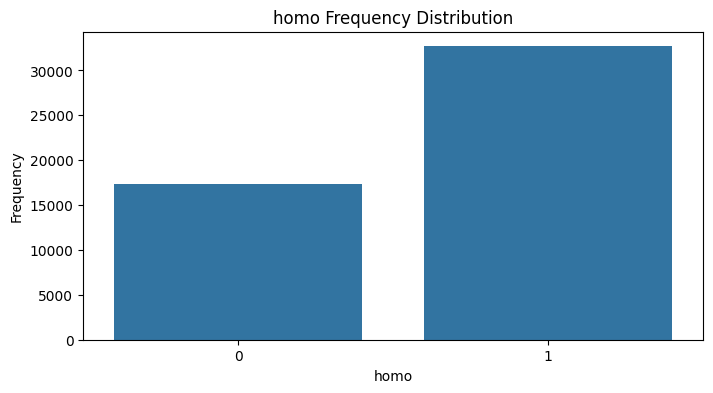

homo
1    32677
0    17323
Name: count, dtype: int64


In [60]:
print("\033[1mhomo: homosexual activity (0=no, 1=yes)\033[0m")
frequency = data['homo'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='homo', data=data)
plt.title('homo Frequency Distribution')
plt.xlabel('homo')
plt.ylabel('Frequency')
plt.show()
print(frequency)

drugs: history of IV drug use (0=no, 1=yes)


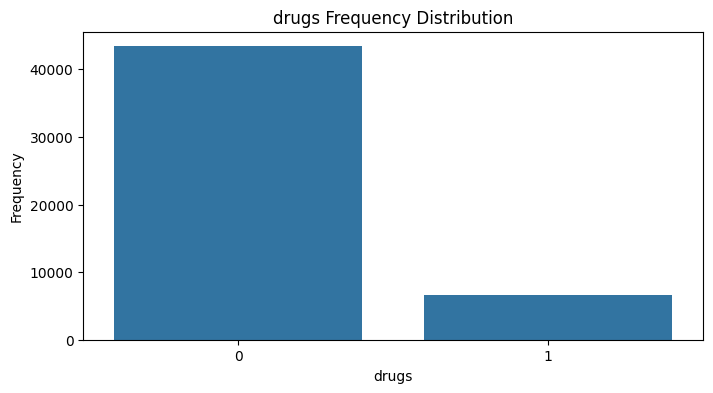

drugs
0    43389
1     6611
Name: count, dtype: int64


In [61]:
print("\033[1mdrugs: history of IV drug use (0=no, 1=yes)\033[0m")
frequency = data['drugs'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='drugs', data=data)
plt.title('drugs Frequency Distribution')
plt.xlabel('drugs')
plt.ylabel('Frequency')
plt.show()
print(frequency)

oprior: Non-ZDV antiretroviral therapy pre-175(0=no,1=yes)


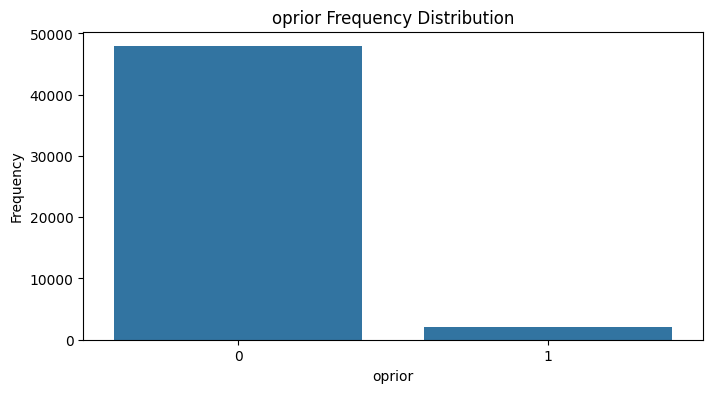

oprior
0    47885
1     2115
Name: count, dtype: int64


In [64]:
print("\033[1moprior: Non-ZDV antiretroviral therapy pre-175(0=no,1=yes)\033[0m")
frequency = data['oprior'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='oprior', data=data)
plt.title('oprior Frequency Distribution')
plt.xlabel('oprior')
plt.ylabel('Frequency')
plt.show()
print(frequency)

z30: ZDV in the 30 days prior to 175 (0=no, 1=yes)


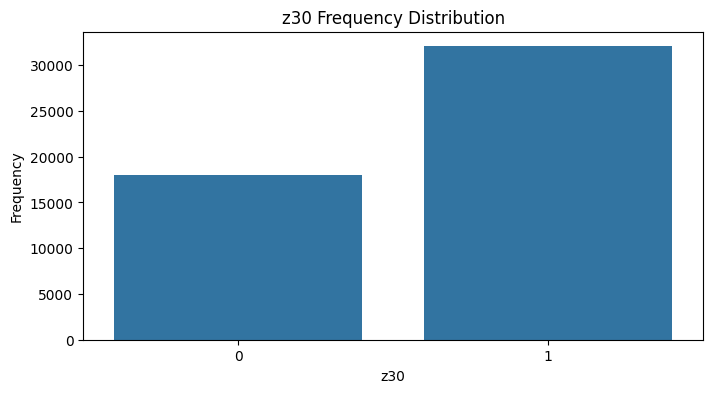

z30
1    32044
0    17956
Name: count, dtype: int64


In [63]:
print("\033[1mz30: ZDV in the 30 days prior to 175 (0=no, 1=yes)\033[0m")
frequency = data['z30'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='z30', data=data)
plt.title('z30 Frequency Distribution')
plt.xlabel('z30')
plt.ylabel('Frequency')
plt.show()
print(frequency)

str2: antiretroviral history (0=naive, 1=experienced)


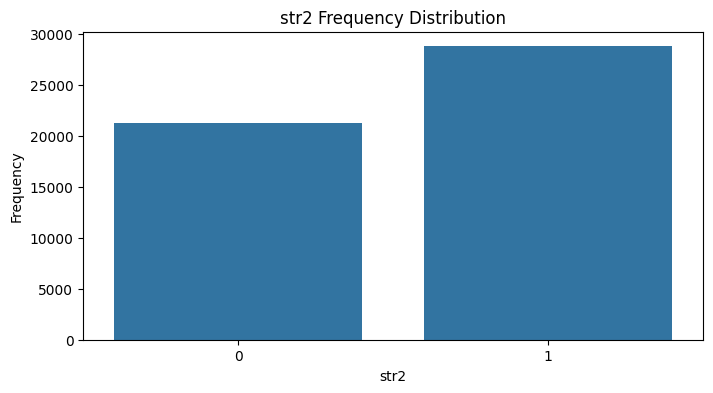

str2
1    28760
0    21240
Name: count, dtype: int64


In [65]:
print("\033[1mstr2: antiretroviral history (0=naive, 1=experienced)\033[0m")
frequency = data['str2'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='str2', data=data)
plt.title('str2 Frequency Distribution')
plt.xlabel('str2')
plt.ylabel('Frequency')
plt.show()
print(frequency)

strat: antiretroviral history stratification (1='Antiretroviral Naive',2='> 1 but <= 52 weeks of prior antiretroviral therapy',3='> 52 weeks)


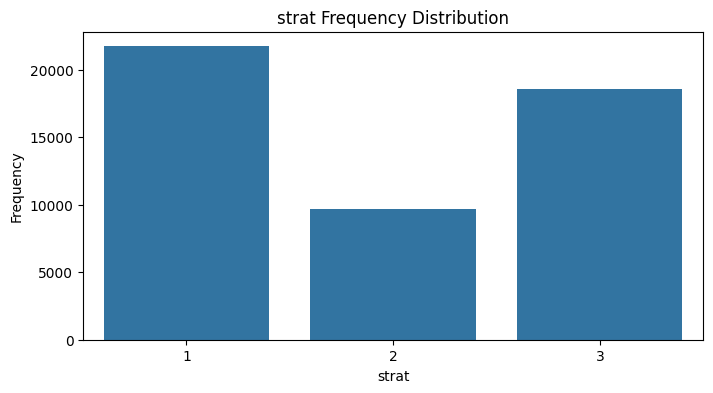

strat
1    21730
3    18551
2     9719
Name: count, dtype: int64


In [66]:
print("\033[1mstrat: antiretroviral history stratification (1='Antiretroviral Naive',2='> 1 but <= 52 weeks of prior antiretroviral therapy',3='> 52 weeks)\033[0m")
frequency = data['strat'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='strat', data=data)
plt.title('strat Frequency Distribution')
plt.xlabel('strat')
plt.ylabel('Frequency')
plt.show()
print(frequency)

symptom: symptomatic indicator (0=asymp, 1=symp)


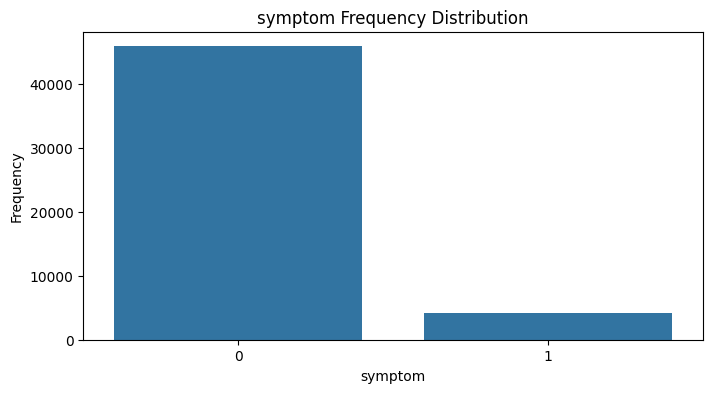

symptom
0    45827
1     4173
Name: count, dtype: int64


In [67]:
print("\033[1msymptom: symptomatic indicator (0=asymp, 1=symp)\033[0m")
frequency = data['symptom'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='symptom', data=data)
plt.title('symptom Frequency Distribution')
plt.xlabel('symptom')
plt.ylabel('Frequency')
plt.show()
print(frequency)

treat: treatment indicator (0=ZDV only, 1=others)


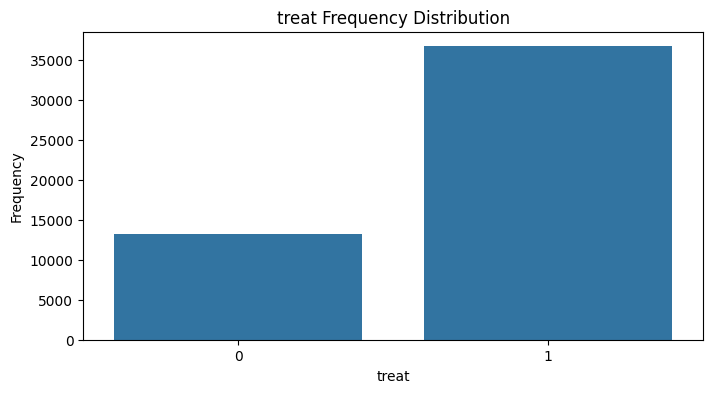

treat
1    36708
0    13292
Name: count, dtype: int64


In [68]:
print("\033[1mtreat: treatment indicator (0=ZDV only, 1=others)\033[0m")
frequency = data['treat'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='treat', data=data)
plt.title('treat Frequency Distribution')
plt.xlabel('treat')
plt.ylabel('Frequency')
plt.show()
print(frequency)

offtrt: indicator of off-trt before 96+/-5 weeks (0=no,1=yes)


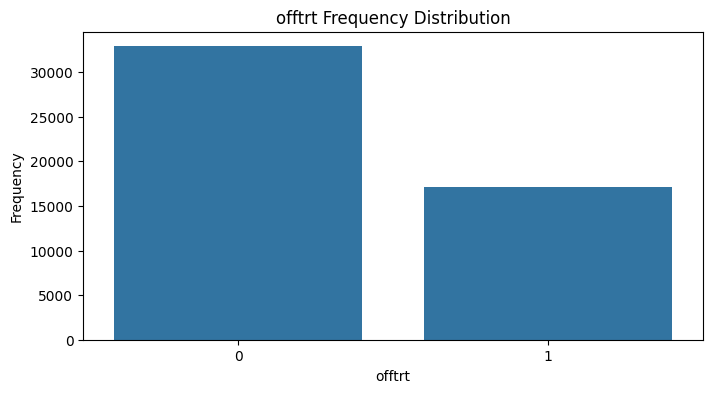

offtrt
0    32889
1    17111
Name: count, dtype: int64


In [69]:
print("\033[1mofftrt: indicator of off-trt before 96+/-5 weeks (0=no,1=yes)\033[0m")
frequency = data['offtrt'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='offtrt', data=data)
plt.title('offtrt Frequency Distribution')
plt.xlabel('offtrt')
plt.ylabel('Frequency')
plt.show()
print(frequency)

infected: is infected with AIDS (0=No, 1=Yes)


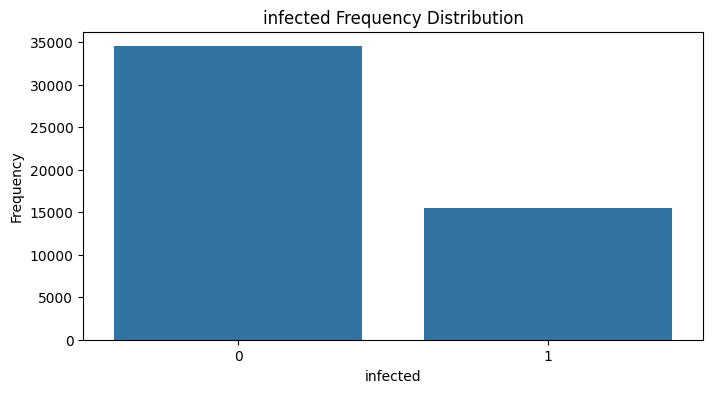

infected
0    34494
1    15506
Name: count, dtype: int64


In [70]:
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
frequency = data['infected'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='infected', data=data)
plt.title('infected Frequency Distribution')
plt.xlabel('infected')
plt.ylabel('Frequency')
plt.show()
print(frequency)

### 013 Temporal analysis



There is no truly timestamped data so we cannot analyze time series for temporal patterns. 
- We do have a "time" variable though, that measures the total time a patient followed the treatment, from start to failure or censoring. 
- We also have the "preanti" variable that measures the time spent in antiretroviral therapy before the beginning of this study. 

In some sense, we can see "preanti" as a time variable that looks into the past, while "time" looks into the future.

Moreover we have the lab variables which were taken at different times in the patient treatment
- cd40 and cd80 are the cell counts per mm3 taken at the beginning of treatment
- cd420 adn cd820 are the cell counts per mm2 taken after 20+-5 weeks of treatment

#### 013-a Preanti and time vs target

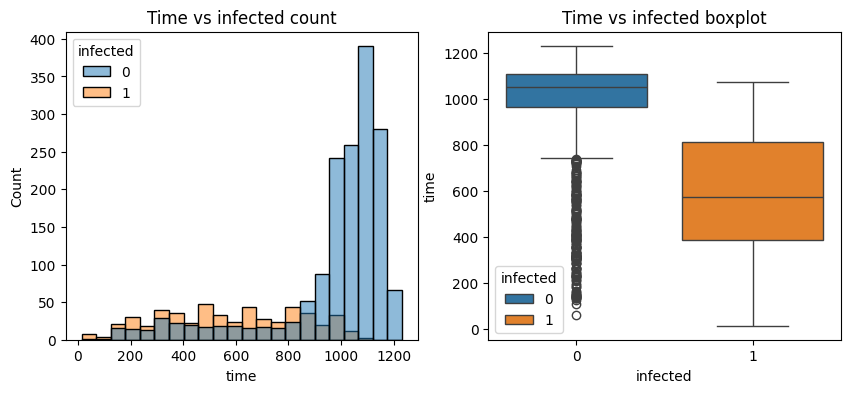

In [42]:
# Plot time vs infected

fig,axes = plt.subplots(1,2,figsize = (10,4), sharey = False)

sns.histplot(data = data, x= "time", hue = "infected", ax = axes[0])
sns.boxplot(data = data, x="infected", y = "time", hue = "infected", orient = "v", ax = axes[1])

axes[0].set_title('Time vs infected count')
axes[1].set_title('Time vs infected boxplot')
plt.show()

Conclusion: patients with time > 3 years thend not to be infected.

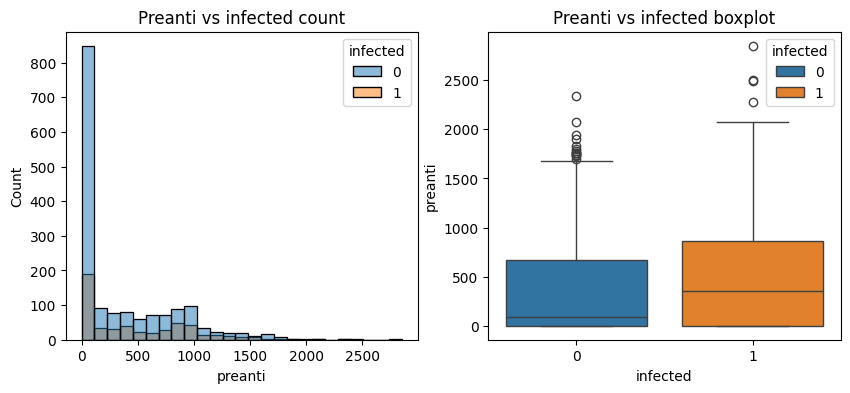

In [43]:
# Plot preanti vs infected

fig,axes = plt.subplots(1,2,figsize = (10,4), sharey = False)

sns.histplot(data = data, x= "preanti", hue = "infected", ax = axes[0])
sns.boxplot(data = data, x="infected", y = "preanti", hue = "infected", orient = "v", ax = axes[1])

axes[0].set_title('Preanti vs infected count')
axes[1].set_title('Preanti vs infected boxplot')
plt.show()

Conclusion: when preanti > 0, the distribution of "preanti" is similar for infected and non-infected patients. When preanti = 0 the proportion of "not-infected" is higher

#### 013-b Lab variables before/after

The individual distribution plots of cd40, cd420, cd80 and cd820 were shown in section 011.

In [24]:
# prepare to plot lab variables vs infected
lab_variables = "cd40 cd420 cd80 cd820 infected".split()
data_tmp = data[lab_variables].copy()
data_tmp["cd420-cd40"] = data_tmp["cd420"]-data_tmp["cd40"]
data_tmp["cd820-cd80"] = data_tmp["cd820"]-data_tmp["cd80"]
data_tmp.head(2)

,cd40,cd420,cd80,cd820,infected,cd420-cd40,cd820-cd80
0,422,477,566,324,0,55,-242
1,162,218,392,564,1,56,172


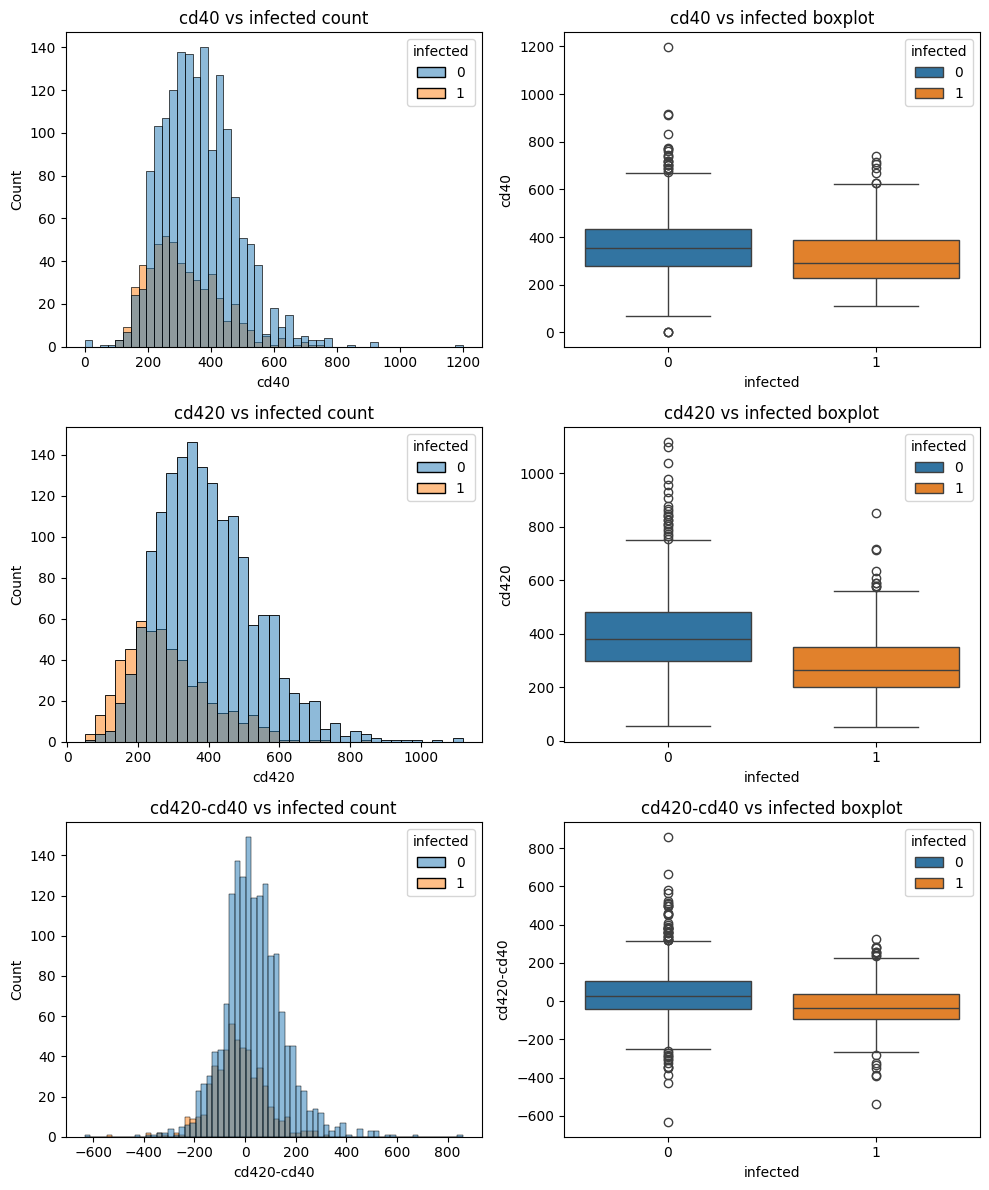

In [26]:
# Plot lab CD4 variables vs infected

fig,axes = plt.subplots(3,2,figsize = (10,12), sharey = False)
for i,variable in enumerate("cd40 cd420 cd420-cd40".split()):

    sns.histplot(data = data_tmp, x= variable, hue = "infected", ax = axes[i,0])
    sns.boxplot(data = data_tmp, x= "infected", y = variable, hue = "infected", orient = "v", ax = axes[i,1])

    axes[i,0].set_title(f'{variable} vs infected count')
    axes[i,1].set_title(f'{variable} vs infected boxplot')
plt.tight_layout()
plt.show()


Chart analysis: cd4 cell counts correlate negatively with being infected. The most notable difference is seen with "cd420" 

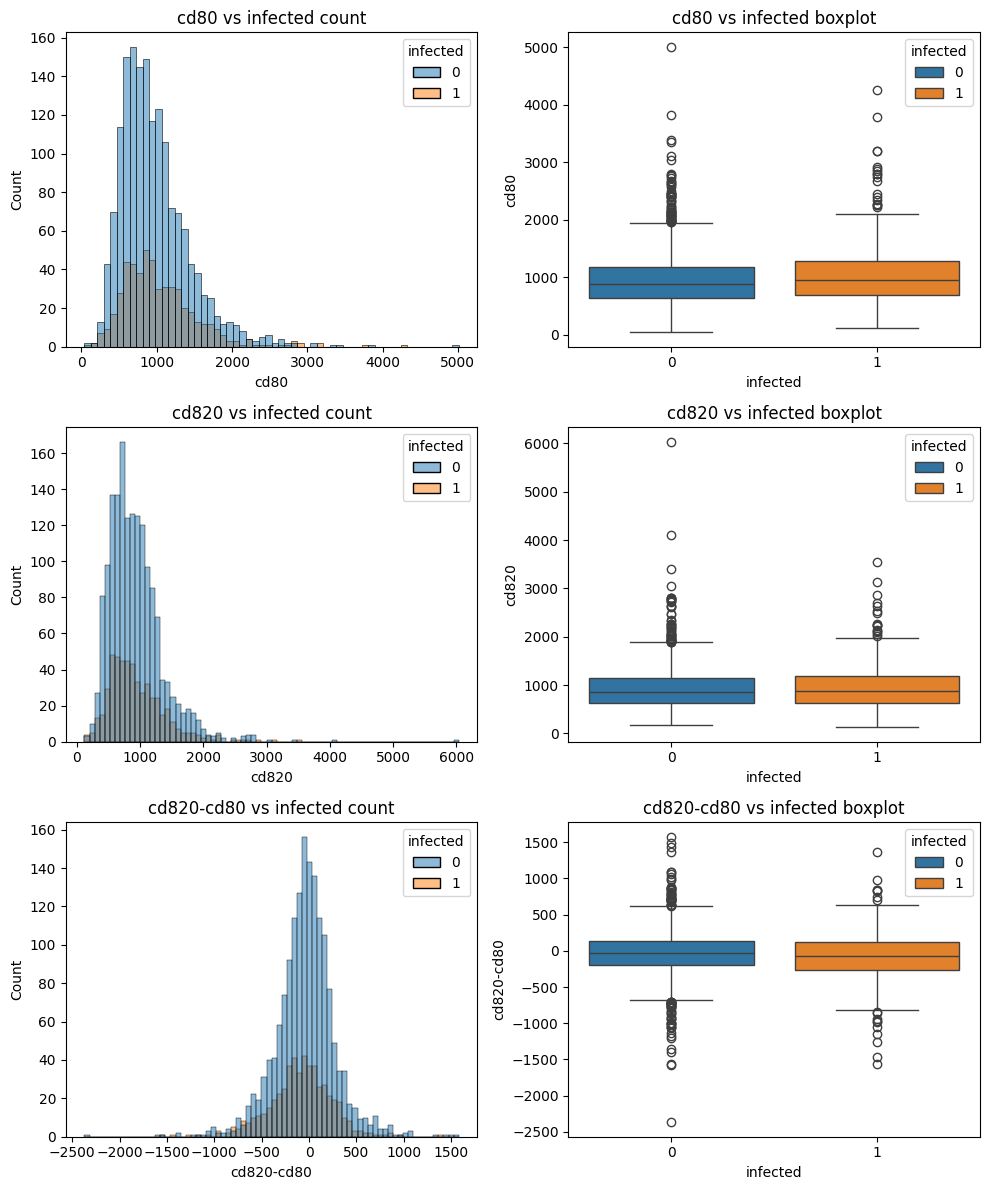

In [29]:
# Plot lab CD8 variables vs infected

fig,axes = plt.subplots(3,2,figsize = (10,12), sharey = False)
for i,variable in enumerate("cd80 cd820 cd820-cd80".split()):

    sns.histplot(data = data_tmp, x= variable, hue = "infected", ax = axes[i,0])
    sns.boxplot(data = data_tmp, x= "infected", y = variable, hue = "infected", orient = "v", ax = axes[i,1])

    axes[i,0].set_title(f'{variable} vs infected count')
    axes[i,1].set_title(f'{variable} vs infected boxplot')
plt.tight_layout()
plt.show()

Chart analysis: CD8 cell counts correlate poorly with being infected. 

### 014 Correlation with target

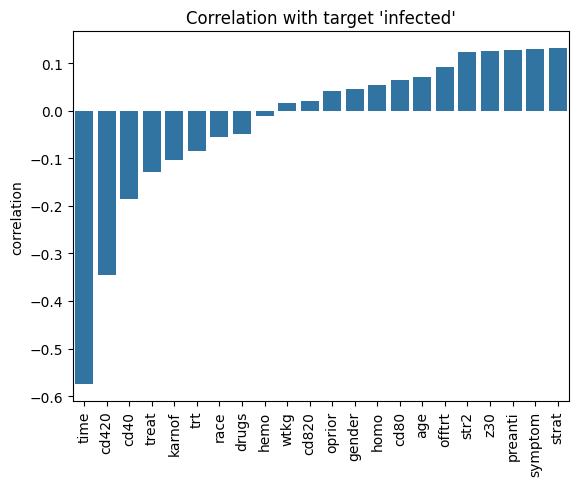

In [85]:
correlations = data.corr().loc['infected'].sort_values()
correlations.drop('infected',inplace = True)
sns.barplot(data = correlations)
plt.xticks(rotation=90)
plt.ylabel ("correlation")
plt.title("Correlation with target 'infected'")

plt.show()

### 015+020 Correlation matrix + Heatmap

In [37]:
data.corr()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
time,1.000000,0.101482,0.026544,0.009225,-0.017501,0.043430,-0.021856,0.094417,-0.016116,0.012898,...,0.010098,0.022033,-0.104611,0.153314,-0.475795,0.191436,0.350611,-0.017425,0.032480,-0.574989
trt,0.101482,1.000000,-0.001931,-0.031685,0.012329,0.025035,0.005712,-0.014573,-0.026805,-0.001656,...,-0.003003,-0.003508,-0.000765,0.775990,-0.043239,-0.012770,0.064448,-0.015665,-0.004595,-0.084360
age,0.026544,-0.001931,1.000000,0.132858,-0.231257,0.158917,0.077446,-0.100041,0.056161,0.061178,...,0.068230,0.089884,0.032814,0.001499,-0.057695,-0.040302,-0.044294,0.046874,0.037458,0.070384
wtkg,0.009225,-0.031685,0.132858,1.000000,-0.075791,0.155909,0.002343,0.034271,0.009607,-0.073841,...,-0.078885,-0.080458,0.003942,-0.040638,-0.003159,0.036401,0.020980,0.090075,0.085447,0.016205
hemo,-0.017501,0.012329,-0.231257,-0.075791,1.000000,-0.391307,-0.092957,0.068403,0.034978,0.111554,...,0.124983,0.141674,-0.076296,0.010786,0.005949,-0.022533,-0.065838,-0.037273,-0.058392,-0.011154
homo,0.043430,0.025035,0.158917,0.155909,-0.391307,1.000000,-0.206876,-0.042072,0.019743,-0.049760,...,-0.036700,-0.022608,0.118575,0.024407,-0.045151,0.000511,0.019915,0.086028,0.082284,0.054279
drugs,-0.021856,0.005712,0.077446,0.002343,-0.092957,-0.206876,1.000000,-0.084558,-0.029968,0.014961,...,0.001106,-0.011319,0.027052,0.022055,0.098031,-0.003360,0.013109,0.014900,0.025728,-0.049794
karnof,0.094417,-0.014573,-0.100041,0.034271,0.068403,-0.042072,-0.084558,1.000000,-0.057291,-0.074947,...,-0.085975,-0.055172,-0.107940,0.001379,-0.103251,0.077730,0.098463,-0.008567,-0.003981,-0.102944
oprior,-0.016116,-0.026805,0.056161,0.009607,0.034978,0.019743,-0.029968,-0.057291,1.000000,-0.037580,...,0.126040,0.134629,0.024199,-0.031801,0.019561,-0.059199,-0.109643,-0.019247,-0.036577,0.041251
z30,0.012898,-0.001656,0.061178,-0.073841,0.111554,-0.049760,0.014961,-0.074947,-0.037580,1.000000,...,0.903417,0.848624,0.020883,0.003776,-0.029318,-0.121282,-0.200149,0.029346,0.018454,0.125488


<Axes: >

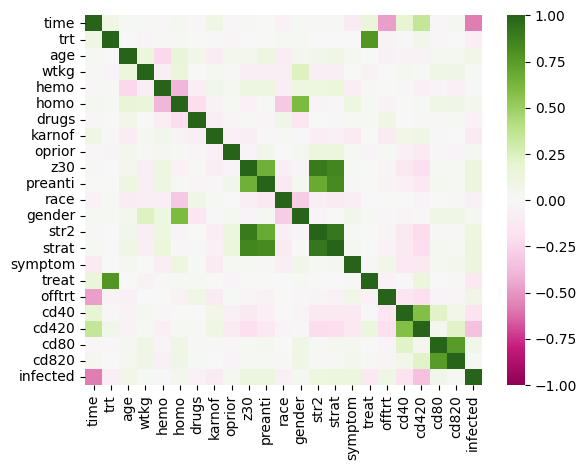

In [41]:
sns.heatmap(data.corr(),cmap="PiYG",vmax = 1, vmin = -1)

Analyis of correlation:
- z30, preanti, st2 and strat are positively correlated to each other (patient antiretroviral history);
- treat is correlated with trt (current treatment);
- gender, homo and -race are moderately correlated (personal info); 
- homo is moderately correlated with -hemo (moderately surprising);
- time is mildly positively correlated with cd40 and cd420, highly negatively correlated with offtrt and infected;
- infected is mostly correlated with time and cd420.


### 016 Simple Feature Engineering

#### 016-trt Dummy variables for treatment



- Treat is a categorical variable with values 0,1,2,3. 
- We replace it with dummy variables in preparation for logistic regression.

In [9]:
def simple_engineer_trt(dataset, drop = True):
    df = dataset.copy()
    df['trt0'] = (df['treat']==0).astype(int)
    df['trt1'] = (df['treat']==1).astype(int)
    df['trt2'] = (df['treat']==2).astype(int)
    if drop:
        df = df.drop(columns = ['trt', 'treat'])
    return df

#### 016-str Remove correlated variables pertaining to previous antiretroviral therapy

There are four highly correlated variables: 
- str2 is binary and equivalent to strat == 1
- z30 is binary and highly correlated with str2
- preanti = 0 is equivalent to strat == 1

We decide to keep only strat, which can be thought essentially both as a simplified version of preanti and as refinement of str2 and z30
- we do not make dummy variables for strat: we treat it as a numerical ordinal variable (with three values)


In [2]:
def simple_engineer_str(dataset, drop = True):
    df = dataset.copy()
    if drop:
        df = df.drop(columns = 'str2 z30 preanti'.split())
    return df

#### 016- Distinguish between time more or less than 2 years

We saw from the EDA that the records with time>800 days and time <800 days correlate very differently with respect to the target 'infected'. That is because the objective of the study was to follow patients for at least 2 years. If they ended the study before the 2 years target, chances are that they had some problem relevant to us. 

We may cut smoothly the two pieces of the distribution "time", but we'll keep it simple and cut abruptly

In [3]:
def simple_engineer_time(dataset, drop = True):
    df = dataset.copy()
    mask_time = (df['time']<730).astype(int)
    df['time<2y'] = df['time'] * mask_time 
    df['time>2y'] = df['time'] * (1-mask_time)
    if drop:
        df = df.drop(columns = ['time'])
    return df

#### 016-cd48  Engineer lab variables

#### 016-simple feature engineer altogether

Another pair of highly correlated variables is cd80 vs cd820. None of them is directly correlated with the target, but cd80 may tell us the state of infection at the beginning of treatment, so it may have interactions with other variables or replace str2 which we dropped. We will keep cd80 and remove cd820.

In [10]:
def simple_engineer(dataset, drop = True):
    df = dataset.copy()
    df = simple_engineer_str(df,drop)
    df = simple_engineer_trt(df,drop)
    df = simple_engineer_time(df,drop)
    if drop:
        df.drop(columns = ['cd820'])
    return df

data_eng_simple = simple_engineer(data)
data_eng_simple.shape

(2139, 22)

<Axes: >

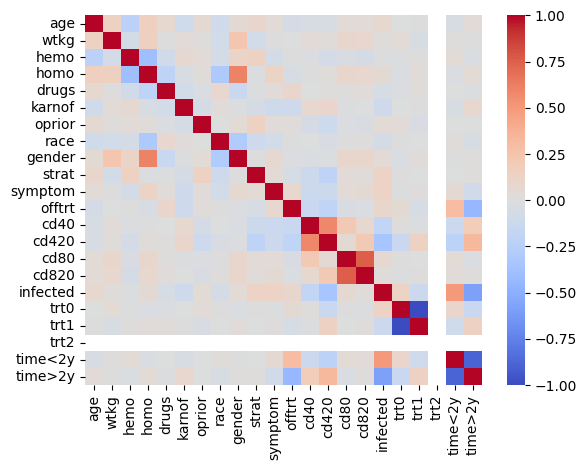

In [11]:
sns.heatmap(data_eng_simple.corr(),cmap='coolwarm', vmin = -1, vmax = 1)

### 017 Numerical outliers

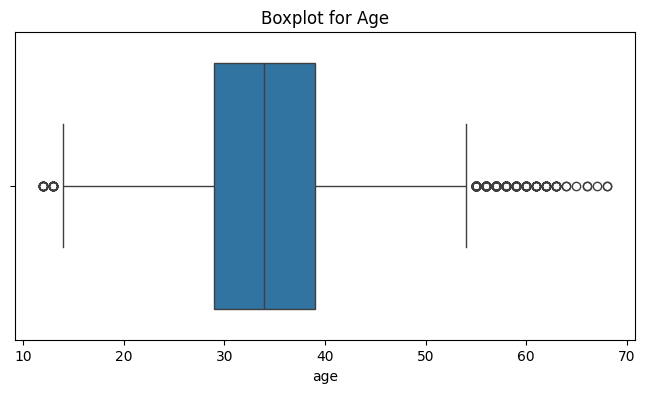

Outliers Below Lower Bound:
       age
333     12
682     12
5942    12
6176    13
6320    13
8650    13
9536    12
12526   12
15990   13
18682   13
19332   12
21207   12
22331   13
22747   13
23125   13
23432   13
25123   12
26457   13
26987   13
28021   12
28067   12
28710   13
30347   13
31031   13
32707   12
33455   12
36925   13
37365   13
39680   13
41276   12
41524   12
43722   12
45025   13
47092   13
48065   13

Outliers Above Upper Bound:
       age
696     57
715     57
736     62
763     60
873     56
...    ...
48894   59
49070   55
49117   58
49205   68
49252   56

[323 rows x 1 columns]


In [89]:
df = pd.read_csv('data/AIDS_Classification.csv')
plt.figure(figsize=(8,4))
sns.boxplot(x=df['age'])
plt.title('Boxplot for Age')
plt.show()

Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_below = df[df['age'] < lower_bound] 
outliers_above = df[df['age'] > upper_bound] 

print("Outliers Below Lower Bound:")
print(outliers_below[['age']])
print("\nOutliers Above Upper Bound:")
print(outliers_above[['age']])


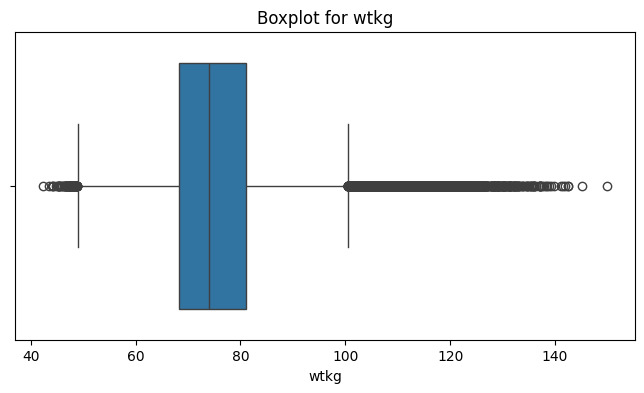

Outliers Below Lower Bound:
           wtkg
34     47.39837
491    48.37318
707    48.09408
2039   46.51549
2738   48.66754
...         ...
48061  44.21877
48129  47.83721
48646  48.11211
49714  46.39468
49785  48.12583

[73 rows x 1 columns]

Outliers Above Upper Bound:
            wtkg
4      137.46581
64     109.31356
88     101.80948
91     109.29427
127    103.22945
...          ...
49907  102.75236
49914  103.18172
49943  100.50035
49973  118.75168
49974  108.71787

[2164 rows x 1 columns]


In [90]:
df = pd.read_csv('data/AIDS_Classification.csv')
plt.figure(figsize=(8,4))
sns.boxplot(x=df['wtkg'])
plt.title('Boxplot for wtkg')
plt.show()

Q1 = df['wtkg'].quantile(0.25)
Q3 = df['wtkg'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_below = df[df['wtkg'] < lower_bound] 
outliers_above = df[df['wtkg'] > upper_bound] 

print("Outliers Below Lower Bound:")
print(outliers_below[['wtkg']])
print("\nOutliers Above Upper Bound:")
print(outliers_above[['wtkg']])

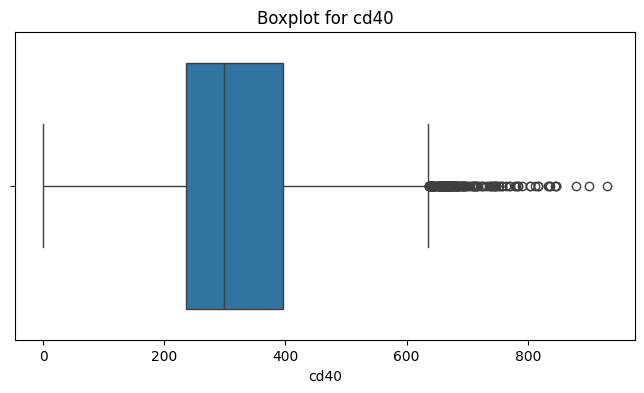

Outliers Below Lower Bound:
Empty DataFrame
Columns: [cd40]
Index: []

Outliers Above Upper Bound:
       cd40
276     674
866     692
1087    678
1201    662
1291    681
...     ...
49416   639
49568   647
49721   637
49807   678
49974   835

[189 rows x 1 columns]


In [91]:
df = pd.read_csv('data/AIDS_Classification.csv')
plt.figure(figsize=(8,4))
sns.boxplot(x=df['cd40'])
plt.title('Boxplot for cd40')
plt.show()

Q1 = df['cd40'].quantile(0.25)
Q3 = df['cd40'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_below = df[df['cd40'] < lower_bound] 
outliers_above = df[df['cd40'] > upper_bound] 

print("Outliers Below Lower Bound:")
print(outliers_below[['cd40']])
print("\nOutliers Above Upper Bound:")
print(outliers_above[['cd40']])

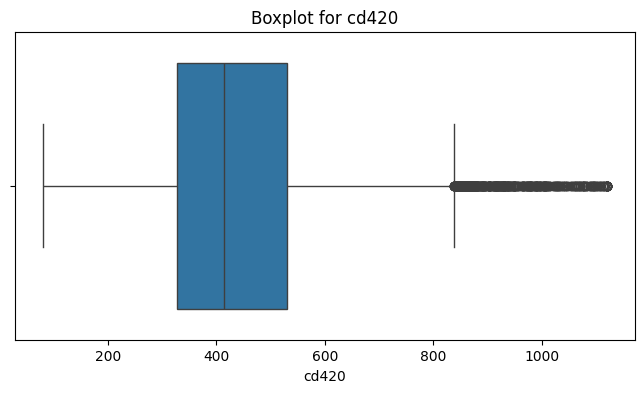

Outliers Below Lower Bound:
Empty DataFrame
Columns: [cd420]
Index: []

Outliers Above Upper Bound:
       cd420
19       847
35       983
60       924
87       977
94      1012
...      ...
49296   1108
49314   1042
49499    879
49715   1022
49893   1115

[388 rows x 1 columns]


In [92]:
df = pd.read_csv('data/AIDS_Classification.csv')
plt.figure(figsize=(8,4))
sns.boxplot(x=df['cd420'])
plt.title('Boxplot for cd420')
plt.show()

Q1 = df['cd420'].quantile(0.25)
Q3 = df['cd420'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_below = df[df['cd420'] < lower_bound] 
outliers_above = df[df['cd420'] > upper_bound] 

print("Outliers Below Lower Bound:")
print(outliers_below[['cd420']])
print("\nOutliers Above Upper Bound:")
print(outliers_above[['cd420']])

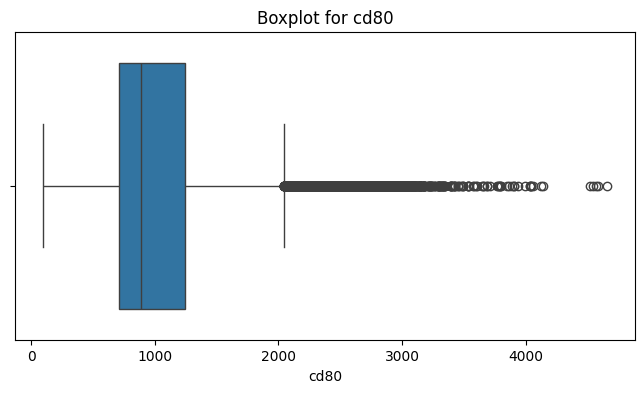

Outliers Below Lower Bound:
Empty DataFrame
Columns: [cd80]
Index: []

Outliers Above Upper Bound:
       cd80
7      2572
12     2423
22     2552
118    3037
124    2139
...     ...
49860  2464
49884  2900
49892  2691
49919  2091
49979  2708

[2618 rows x 1 columns]


In [93]:
df = pd.read_csv('data/AIDS_Classification.csv')
plt.figure(figsize=(8,4))
sns.boxplot(x=df['cd80'])
plt.title('Boxplot for cd80')
plt.show()

Q1 = df['cd80'].quantile(0.25)
Q3 = df['cd80'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_below = df[df['cd80'] < lower_bound] 
outliers_above = df[df['cd80'] > upper_bound] 

print("Outliers Below Lower Bound:")
print(outliers_below[['cd80']])
print("\nOutliers Above Upper Bound:")
print(outliers_above[['cd80']])

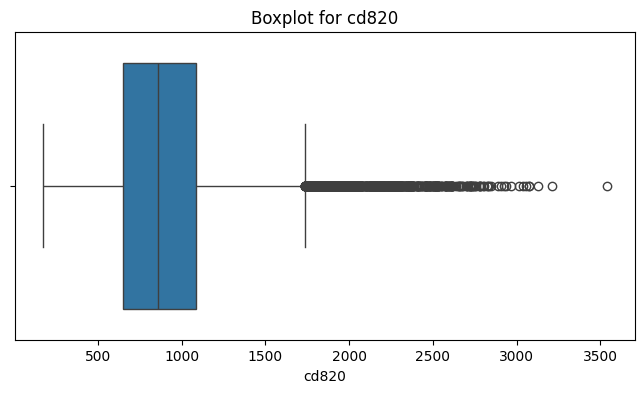

Outliers Below Lower Bound:
Empty DataFrame
Columns: [cd820]
Index: []

Outliers Above Upper Bound:
       cd820
30      1785
91      2077
149     2146
153     1804
154     2576
...      ...
49859   2260
49886   1789
49918   1830
49967   1934
49976   1889

[1095 rows x 1 columns]


In [94]:
df = pd.read_csv('data/AIDS_Classification.csv')
plt.figure(figsize=(8,4))
sns.boxplot(x=df['cd820'])
plt.title('Boxplot for cd820')
plt.show()

Q1 = df['cd820'].quantile(0.25)
Q3 = df['cd820'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_below = df[df['cd820'] < lower_bound] 
outliers_above = df[df['cd820'] > upper_bound] 

print("Outliers Below Lower Bound:")
print(outliers_below[['cd820']])
print("\nOutliers Above Upper Bound:")
print(outliers_above[['cd820']])

## 018 Categorical Relationships ##

trt: treatment indicator (0 = ZDV only; 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only)
infected: is infected with AIDS (0=No, 1=Yes)


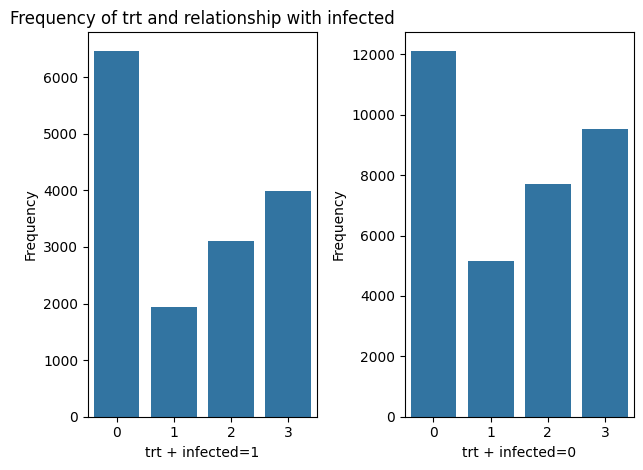

In [24]:
print("\033[1mtrt: treatment indicator (0 = ZDV only; 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='trt', data=filtered_data, ax=axes[0])
sns.countplot(x='trt', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("trt + infected=1")
axes[1].set_xlabel("trt + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of trt and relationship with infected")
plt.tight_layout()
plt.show()

hemo: hemophilia (0=no, 1=yes)
infected: is infected with AIDS (0=No, 1=Yes)


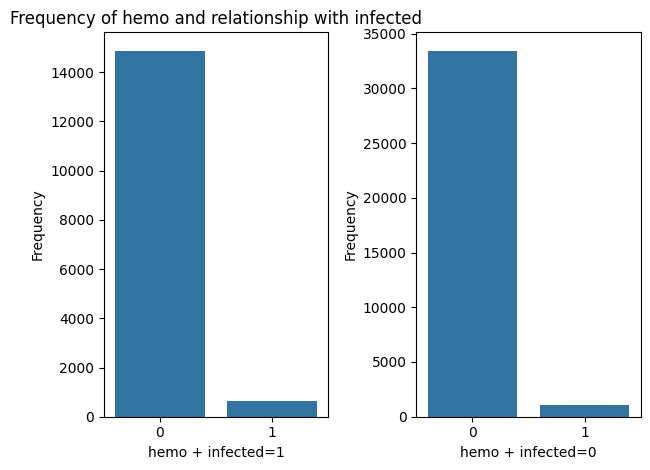

In [34]:
print("\033[1mhemo: hemophilia (0=no, 1=yes)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='hemo', data=filtered_data, ax=axes[0])
sns.countplot(x='hemo', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("hemo + infected=1")
axes[1].set_xlabel("hemo + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of hemo and relationship with infected")
plt.tight_layout()
plt.show()

homo: homosexual activity (0=no, 1=yes)
infected: is infected with AIDS (0=No, 1=Yes)


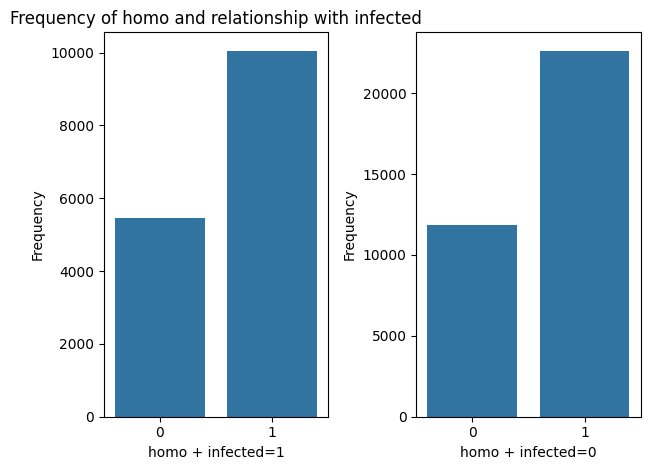

In [33]:
print("\033[1mhomo: homosexual activity (0=no, 1=yes)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='homo', data=filtered_data, ax=axes[0])
sns.countplot(x='homo', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("homo + infected=1")
axes[1].set_xlabel("homo + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of homo and relationship with infected")
plt.tight_layout()
plt.show()

drugs: history of IV drug use (0=no, 1=yes)
infected: is infected with AIDS (0=No, 1=Yes)


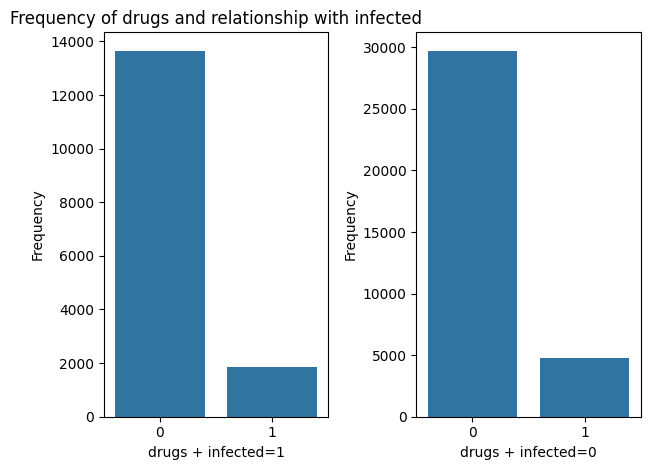

In [32]:
print("\033[1mdrugs: history of IV drug use (0=no, 1=yes)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='drugs', data=filtered_data, ax=axes[0])
sns.countplot(x='drugs', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("drugs + infected=1")
axes[1].set_xlabel("drugs + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of drugs and relationship with infected")
plt.tight_layout()
plt.show()

oprior: Non-ZDV antiretroviral therapy pre-175 (0=no, 1=yes)
infected: is infected with AIDS (0=No, 1=Yes)


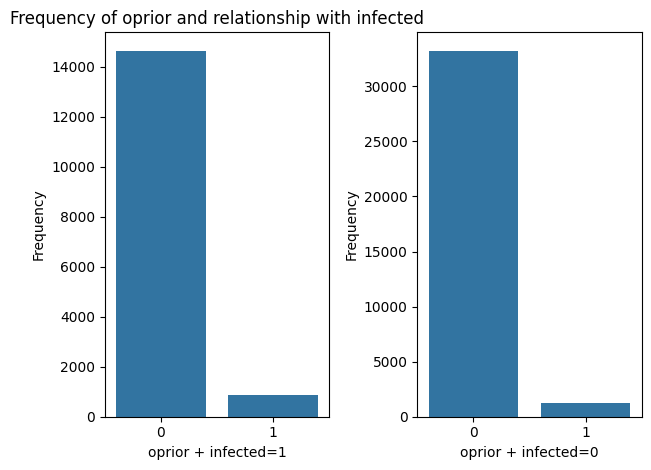

In [31]:
print("\033[1moprior: Non-ZDV antiretroviral therapy pre-175 (0=no, 1=yes)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='oprior', data=filtered_data, ax=axes[0])
sns.countplot(x='oprior', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("oprior + infected=1")
axes[1].set_xlabel("oprior + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of oprior and relationship with infected")
plt.tight_layout()
plt.show()

z30: ZDV in the 30 days prior to 175 (0=no, 1=yes)
infected: is infected with AIDS (0=No, 1=Yes)


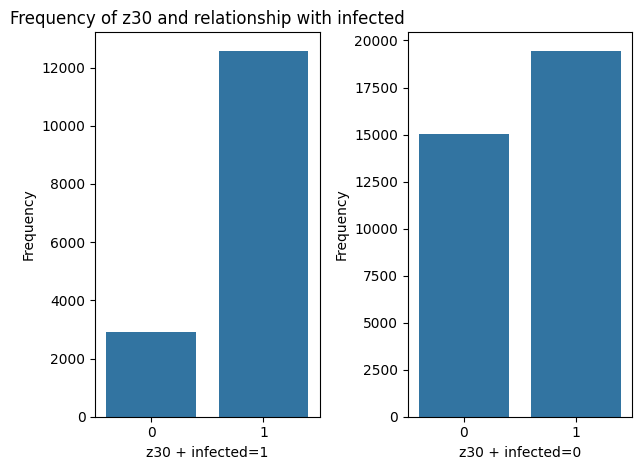

In [30]:
print("\033[1mz30: ZDV in the 30 days prior to 175 (0=no, 1=yes)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='z30', data=filtered_data, ax=axes[0])
sns.countplot(x='z30', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("z30 + infected=1")
axes[1].set_xlabel("z30 + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of z30 and relationship with infected")
plt.tight_layout()
plt.show()

str2: antiretroviral history (0=naive, 1=experienced)
infected: is infected with AIDS (0=No, 1=Yes)


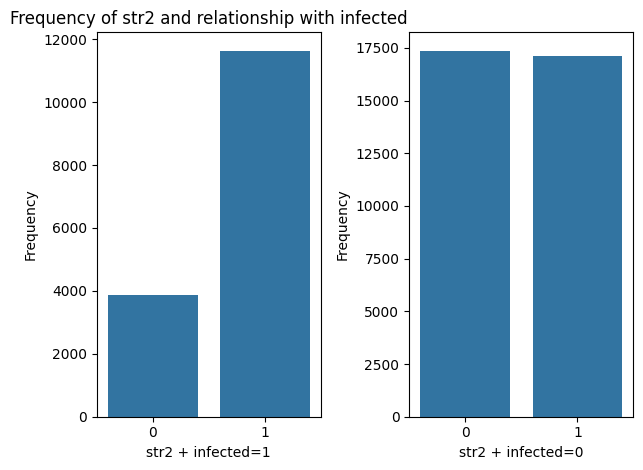

In [35]:
print("\033[1mstr2: antiretroviral history (0=naive, 1=experienced)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='str2', data=filtered_data, ax=axes[0])
sns.countplot(x='str2', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("str2 + infected=1")
axes[1].set_xlabel("str2 + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of str2 and relationship with infected")
plt.tight_layout()
plt.show()

strat: antiretroviral history stratification (1='Antiretroviral Naive',2='> 1 but <= 52 weeks of prior antiretroviral therapy',3='> 52 weeks)
infected: is infected with AIDS (0=No, 1=Yes)


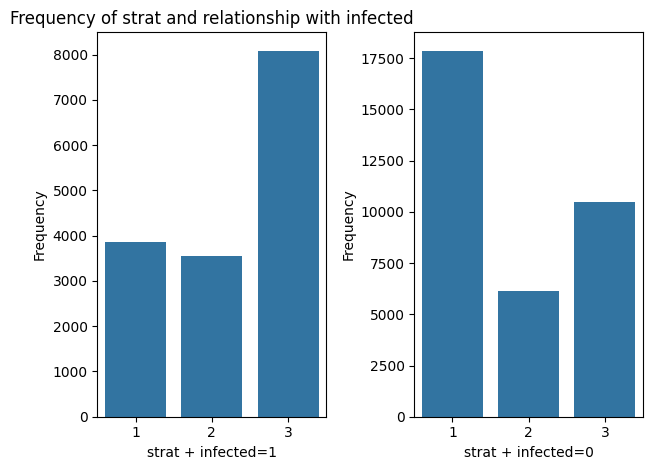

In [36]:
print("\033[1mstrat: antiretroviral history stratification (1='Antiretroviral Naive',2='> 1 but <= 52 weeks of prior antiretroviral therapy',3='> 52 weeks)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='strat', data=filtered_data, ax=axes[0])
sns.countplot(x='strat', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("strat + infected=1")
axes[1].set_xlabel("strat + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of strat and relationship with infected")
plt.tight_layout()
plt.show()

symptom: symptomatic indicator (0=asymp, 1=symp)
infected: is infected with AIDS (0=No, 1=Yes)


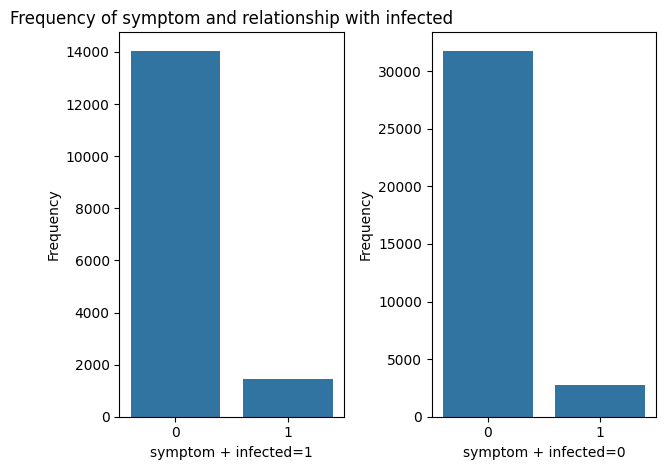

In [37]:
print("\033[1msymptom: symptomatic indicator (0=asymp, 1=symp)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='symptom', data=filtered_data, ax=axes[0])
sns.countplot(x='symptom', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("symptom + infected=1")
axes[1].set_xlabel("symptom + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of symptom and relationship with infected")
plt.tight_layout()
plt.show()

treat: treatment indicator (0=ZDV only, 1=others)
infected: is infected with AIDS (0=No, 1=Yes)


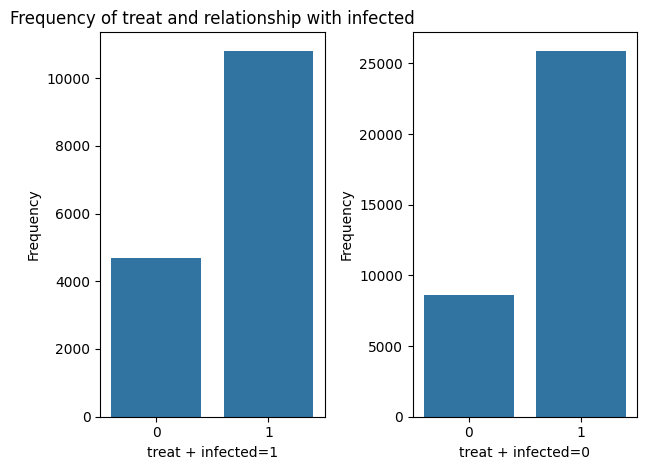

In [38]:
print("\033[1mtreat: treatment indicator (0=ZDV only, 1=others)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='treat', data=filtered_data, ax=axes[0])
sns.countplot(x='treat', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("treat + infected=1")
axes[1].set_xlabel("treat + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of treat and relationship with infected")
plt.tight_layout()
plt.show()

offtrt: indicator of off-trt before 96+/-5 weeks (0=no,1=yes)
infected: is infected with AIDS (0=No, 1=Yes)


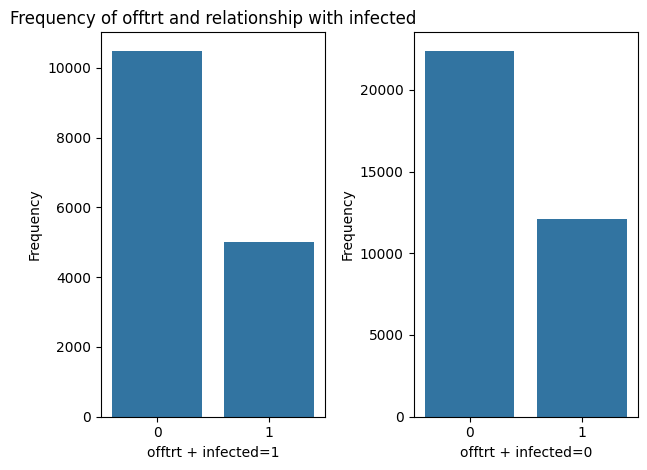

In [39]:
print("\033[1mofftrt: indicator of off-trt before 96+/-5 weeks (0=no,1=yes)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='offtrt', data=filtered_data, ax=axes[0])
sns.countplot(x='offtrt', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("offtrt + infected=1")
axes[1].set_xlabel("offtrt + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of offtrt and relationship with infected")
plt.tight_layout()
plt.show()

### 019 Conditioned plots

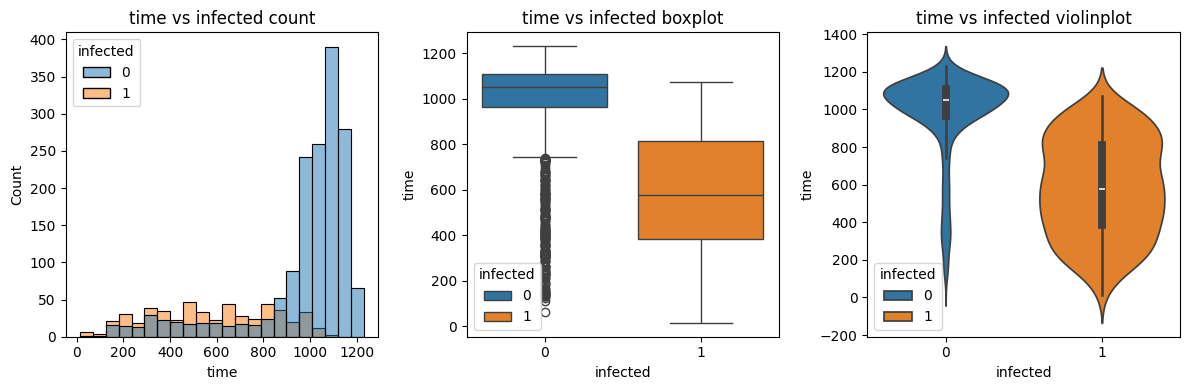

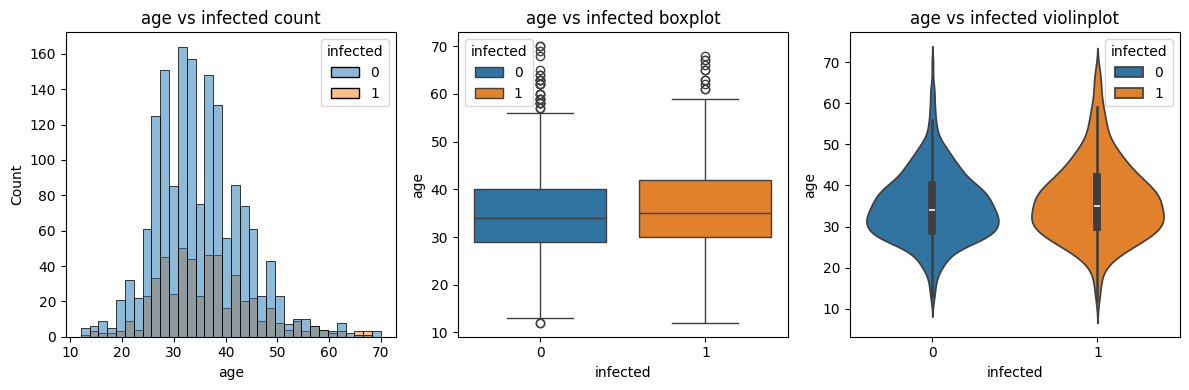

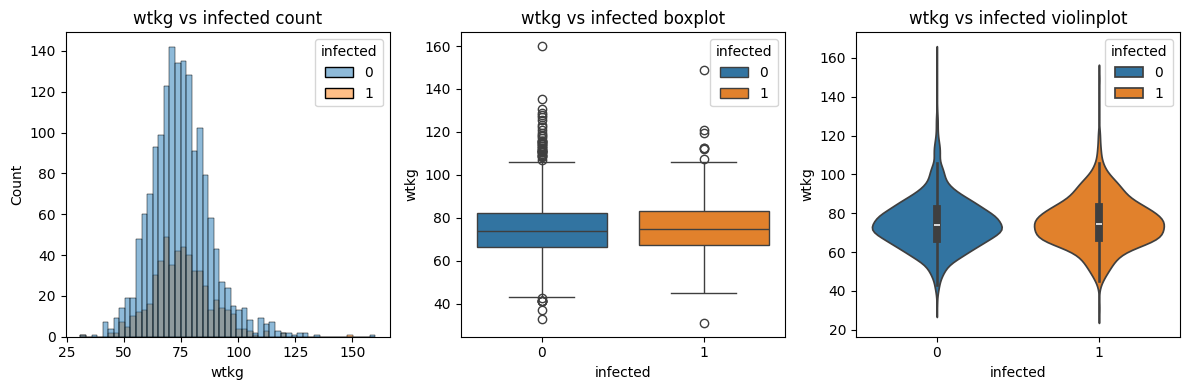

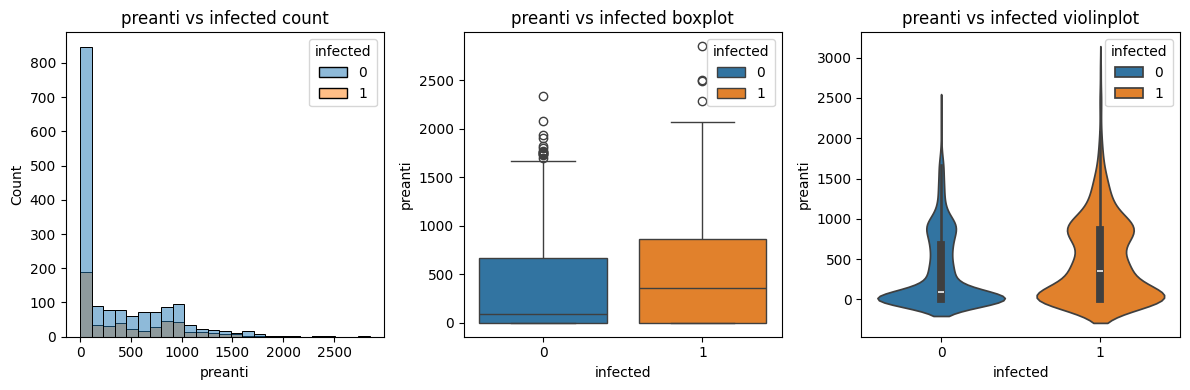

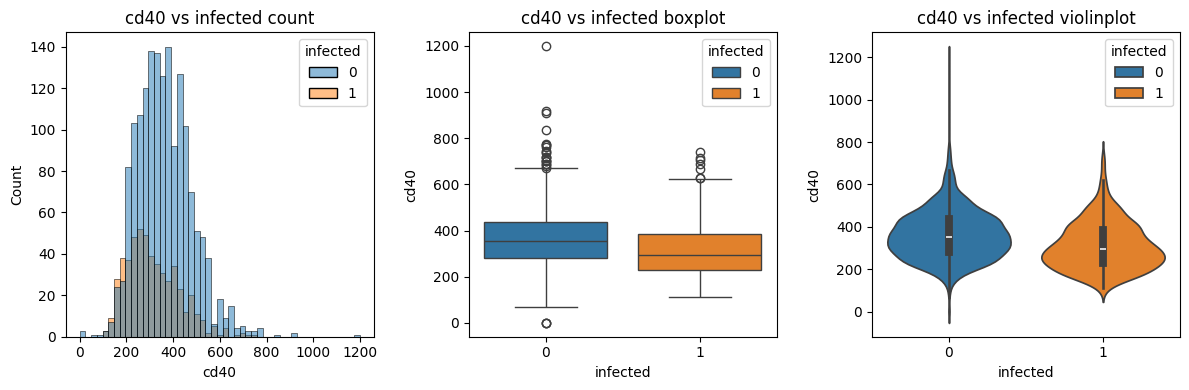

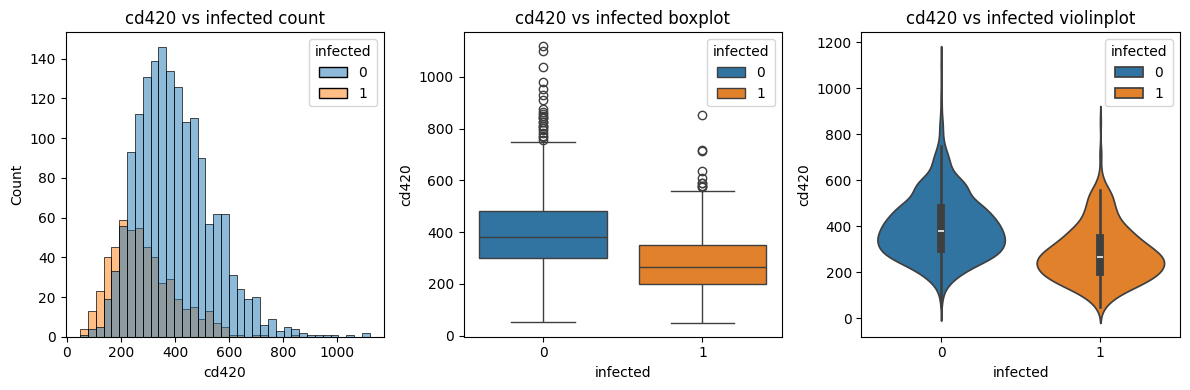

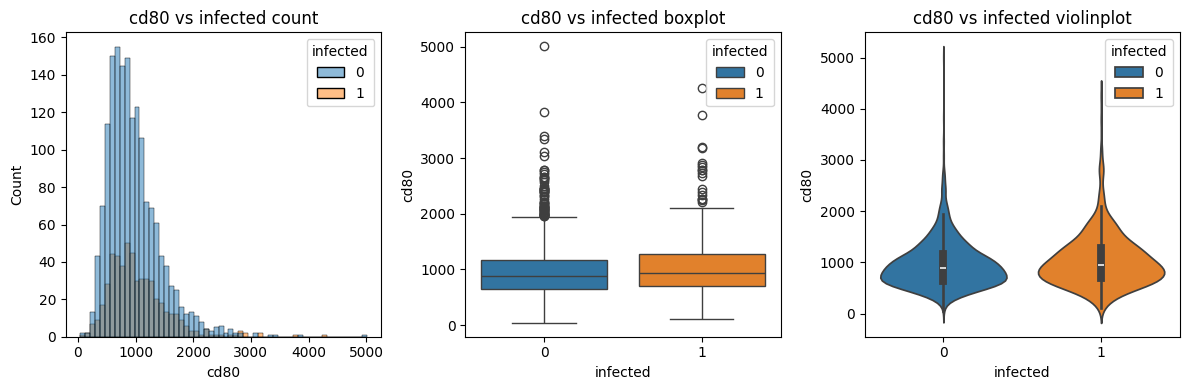

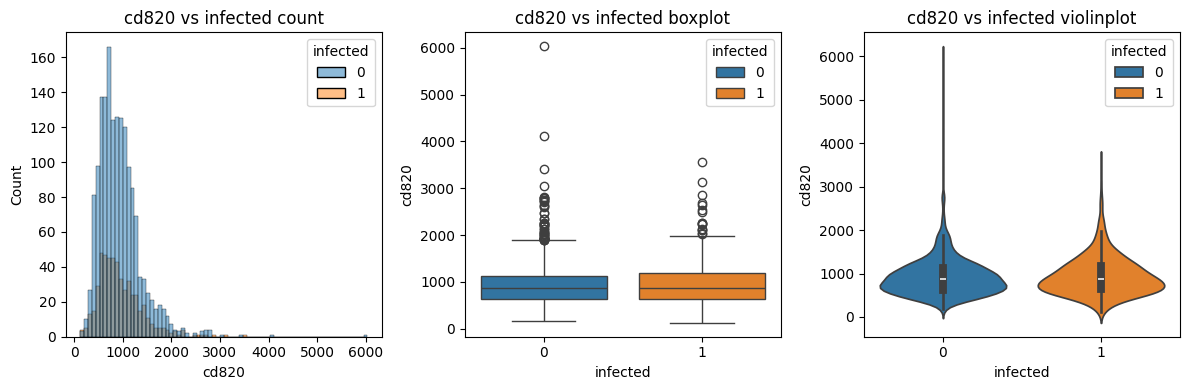

In [86]:
continuous_variables .remove('karnof')
for variable in continuous_variables:
    fig,axes = plt.subplots(1,3,figsize = (12,4), sharey = False)

    sns.histplot(data = data, x= variable, hue = "infected", ax = axes[0])
    sns.boxplot(data = data, x= "infected", y = variable, hue = "infected", orient = "v", ax = axes[1])
    sns.violinplot(data = data, x= "infected", y = variable, hue = "infected", orient = "v", ax = axes[2])


    axes[0].set_title(f'{variable} vs infected count')
    axes[1].set_title(f'{variable} vs infected boxplot')
    axes[2].set_title(f'{variable} vs infected violinplot')

    plt.tight_layout()
    plt.show()

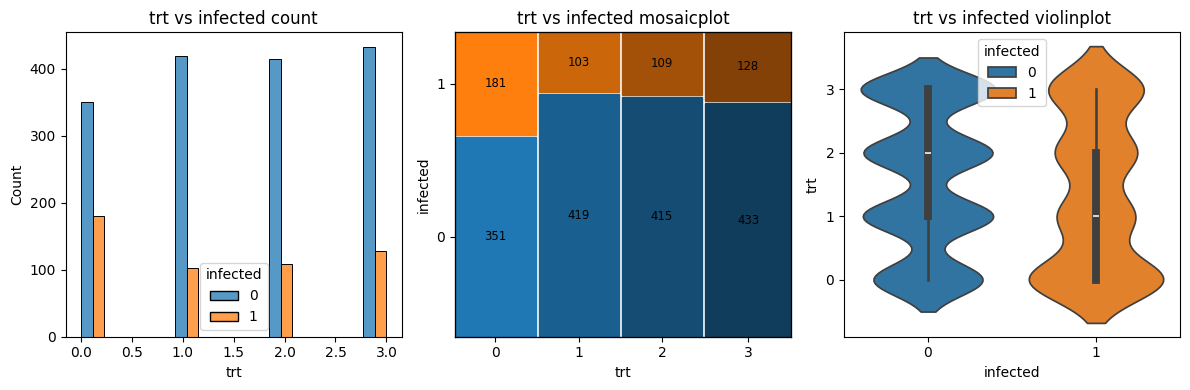

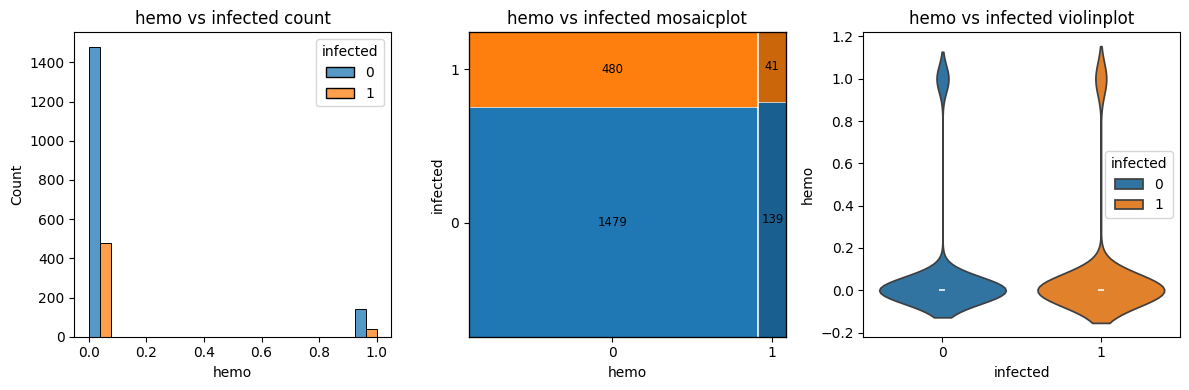

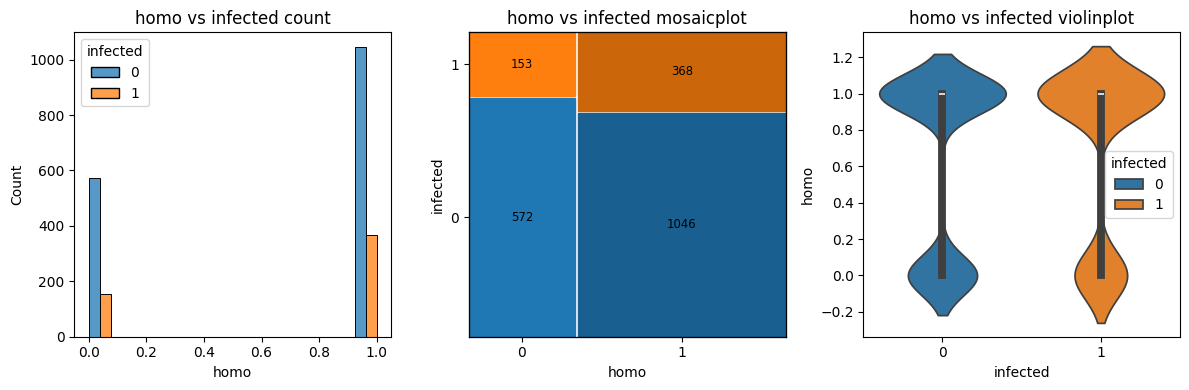

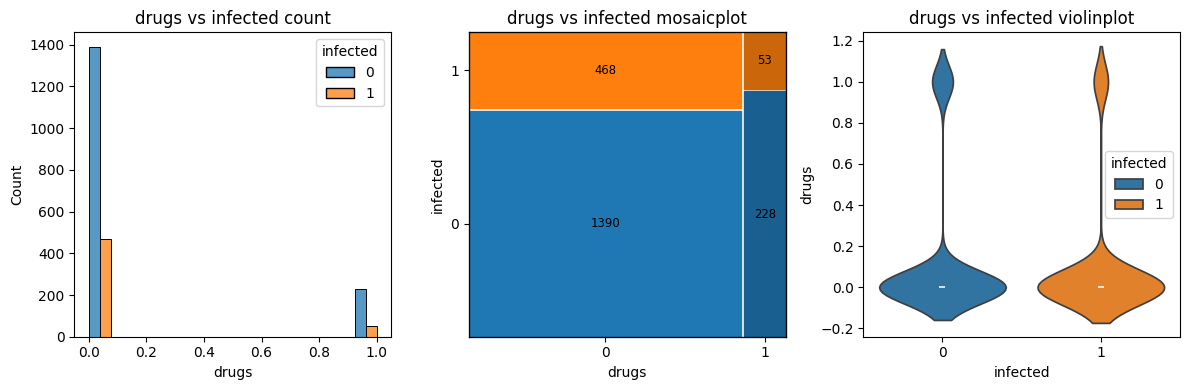

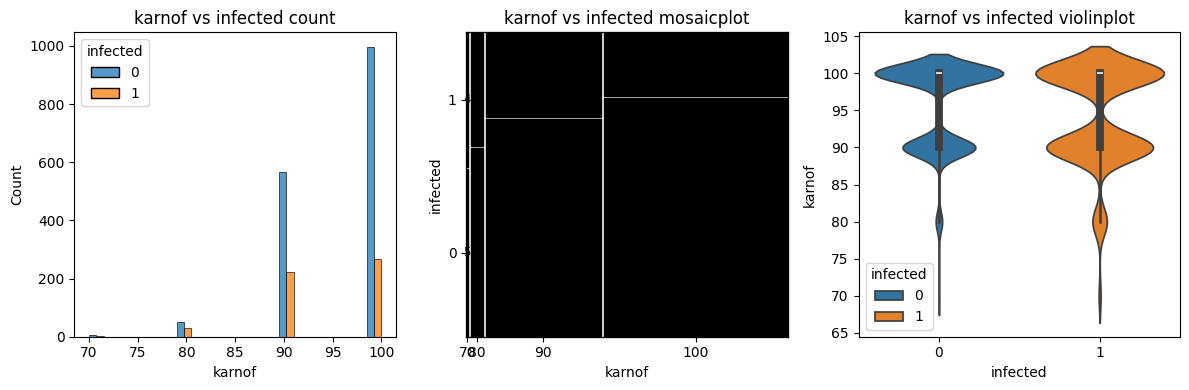

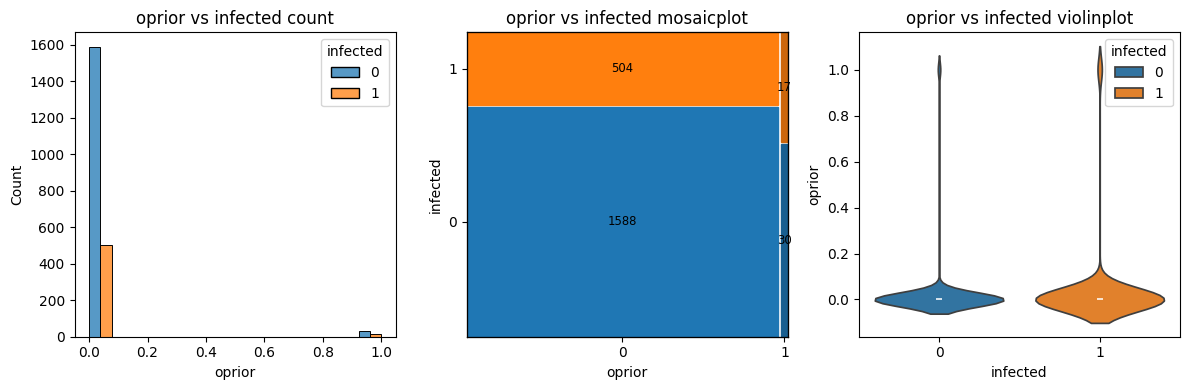

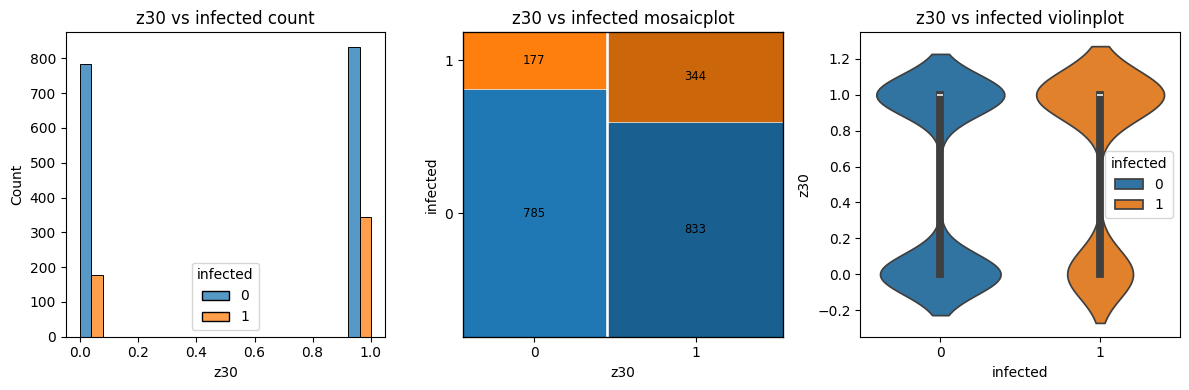

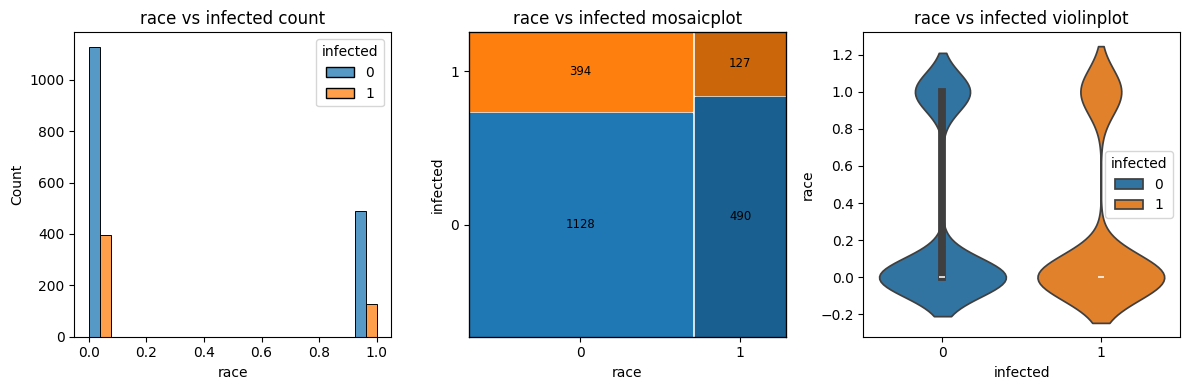

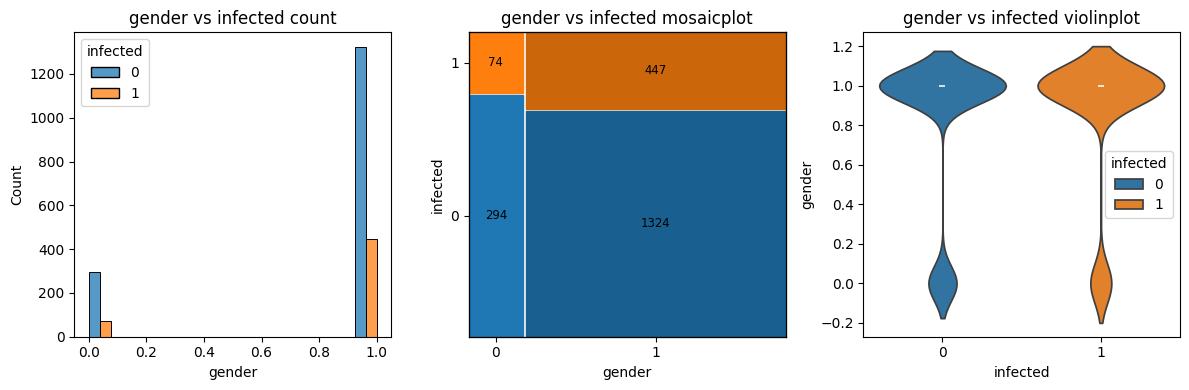

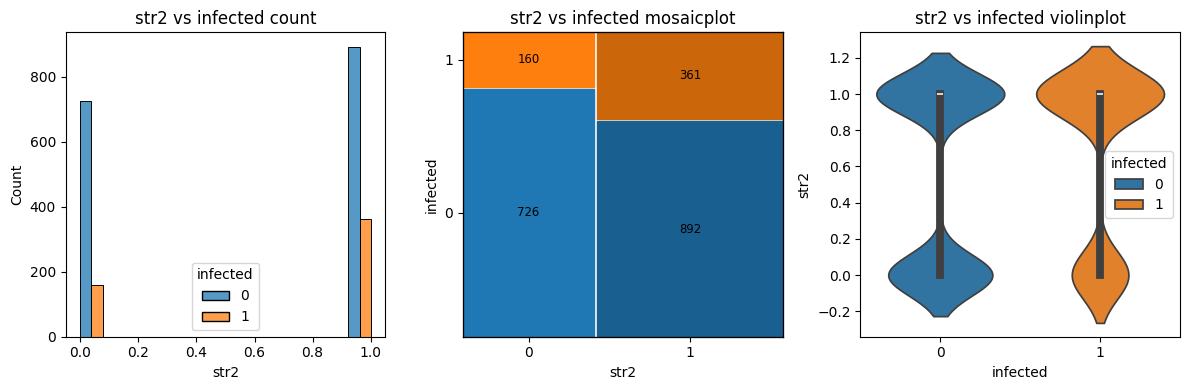

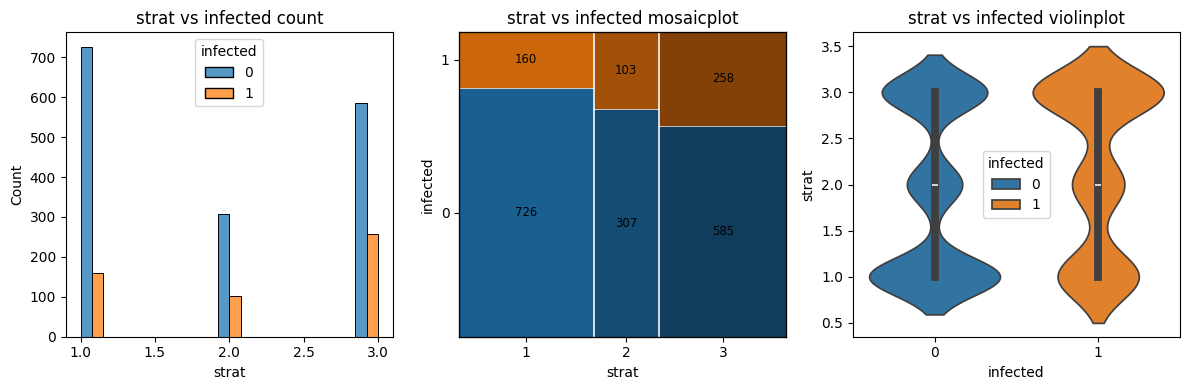

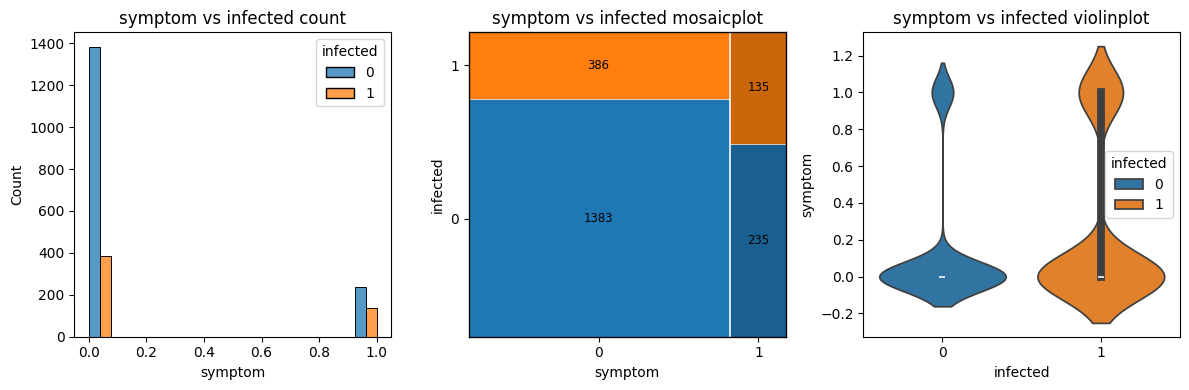

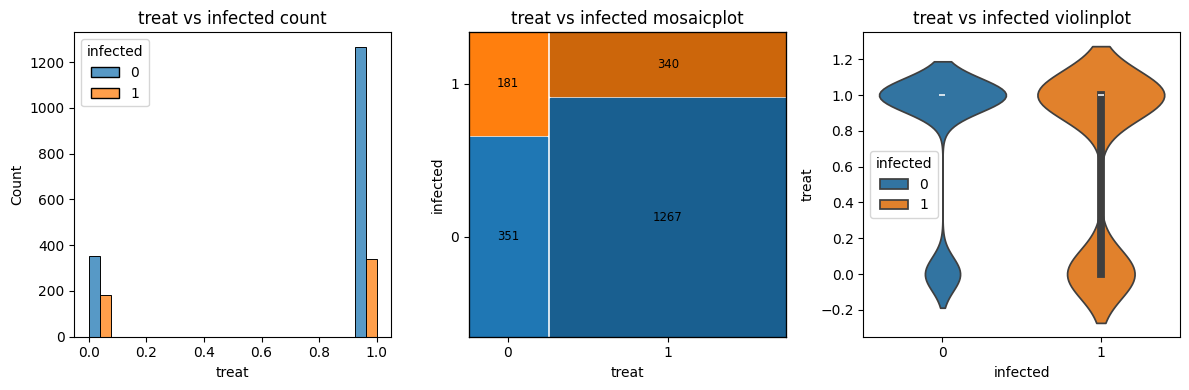

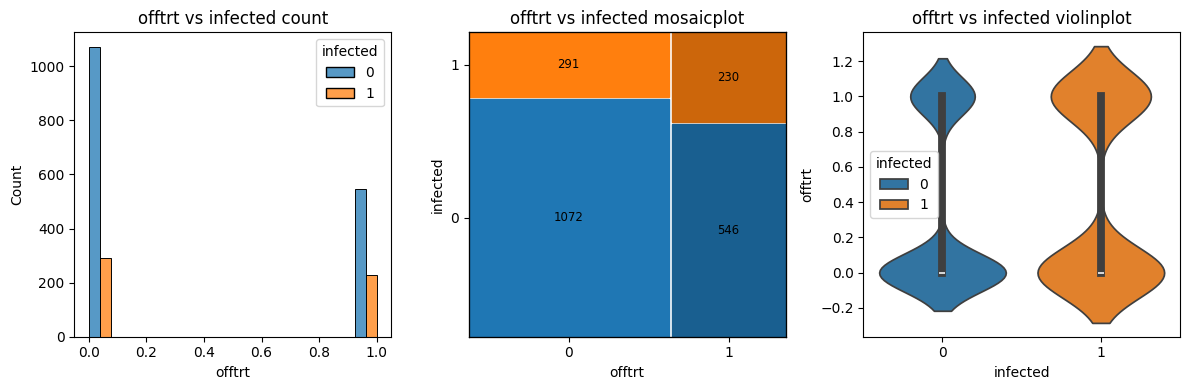

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic

def mosaic_colors(key):
    colors = sns.color_palette()
    infected = int(key[1])
    variable = int(key[0])
    base_color_rgb = colors[0] if infected == 0 else colors[1]
    scale_color = (0.8)**variable
    return_color = [x*scale_color for x in base_color_rgb]
    return {'color': return_color}


df = data.copy()
df['karnof/100'] = df['karnof']/100 # for the color of mosaicplot

categorical_features = [col for col in data.columns if col not in continuous_variables and col != 'infected']
categorical_features.remove('karnof')
categorical_features.append('karnof/100')
for variable in categorical_features:
    fig,axes = plt.subplots(1,3,figsize = (12,4), sharey = False)

    sns.histplot(data = data, x= variable, hue = "infected", multiple = "dodge", ax = axes[0])
    mosaic(data.sort_values(by=[variable,"infected"]), [variable,'infected'], axes_label = True, gap = 0.01, ax = axes[1],
        properties = mosaic_colors,
        labelizer = lambda key : str(data.groupby([variable,'infected']).size()[int(key[0]),int(key[1])])
    )
    sns.violinplot(data = data, x= "infected", y = variable, hue = "infected", orient = "v", ax = axes[2])


    axes[0].set_title(f'{variable} vs infected count')
    axes[1].set_title(f'{variable} vs infected mosaicplot')
    axes[1].set_xlabel(f"{variable}")
    axes[1].set_ylabel("infected")
    axes[2].set_title(f'{variable} vs infected violinplot')

    plt.tight_layout()
    plt.show()

## 022 Potential gaps or limitations in the dataset

#### Missing med variables 

Problems with the end reason of treatment
- the variable "time" tells us the total time a patient followed the treatment till failure or censoring. However, the data does not tell us the full story of the ending of treatment. Censoring could be among, but not limited to, the following reasons:
    - patient lost to follow-up
    - death
    - patient change tratment because of medical reasons
    - end of clinical study
- although the endstate should not be a regressor in the machine learning model, it could have been a feature to learn for an intermediate model.

Missing specification of symptoms and karnofsky score
- could be useful to know if the patient experiences 
    - weight loss, 
    - abnormal liver markers 
    - other medical data related to early AIDS diagnosis



#### Imbalancedness

Imbalanced target
- we have "infected = 1" only for 26% of records

Imbalanced features
- there are some notable under-represented categories, namely
    - gender = 0
    - drugs = 1
    - hemo = 1
    - karnof < 90

Some very under-represented features
- There is very limited data with respect to the following categories
    - oprior = 1
    - karnof = 70

#### Outliers

The following datapoints should be considered as outliers and managed with care
- wtkg > 110
- age < 18  or age > 60
- cd40, cd420 > 800
- cd80, cd820 > 2500

The time distributions are very skewed
- time is mostly supported on time > 800 but has uniform outliers in [0,800]
- preanti is mostly supported on preanti= 0 (where it is equivalent to st2 = 0 or strat = 1)

The lab distributions are supported on the nonnegative numbers
- therefore they are positively skewed

# Sprint 2

### 026 Preprocessing - Balance Dataset

As we saw in section [009 Target class imbalance](#009) the target feature is imbalanced. There are 1618 vs 521 datapoints for the classes infected and not infected. 
- We implement a simple balancing strategy.

In [7]:
def sample_balance_df(dataset, with_reindex = False):
    df = dataset.copy()
    df_infected = df[df['infected']==1] 
    df_not_infected = df[df['infected']==0]

    num_infected = df_infected.shape[0]
    df_sample_not_infected = df_not_infected.sample(num_infected, random_state=42)

    df_balanced = pd.concat([df_infected,df_sample_not_infected])
    # we shuffle it once more at the end.
    # https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
    if with_reindex:
        df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
    else:
        df_balanced = df_balanced.sample(frac=1)
    return df_balanced

data_original = data.copy()
data_balanced = sample_balance_df(data_original)
print(data_balanced.shape)

(1042, 23)


### 027 Show balancing impact

The new data is balanced with respect to the target variable 'infected'

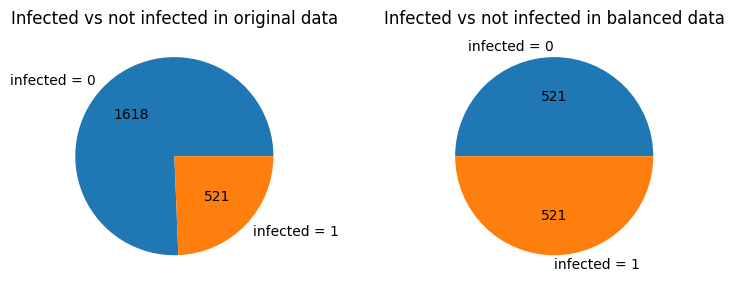

In [8]:
fig,ax = plt.subplots(1,2, figsize = (8,3))

for i,df in enumerate([data_original, data_balanced]):
        num_data = df.shape[0]
        text_data = ["original data", "balanced data"][i]
        ax[i].pie(df['infected'].value_counts(), 
                labels = ["infected = 0", "infected = 1"], 
                colors = sns.color_palette(), 
                autopct= lambda p: f'{int(num_data * p / 100 )}') # to compute the count instead of the percentage
        ax[i].set_title(f"Infected vs not infected in {text_data}")

plt.tight_layout()
plt.show()



### 028 Train test split

In [9]:
df = data_balanced
X = df.drop("infected",axis=1)
y = df['infected']

X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)


In [10]:
df_train = pd.concat([X_train, y_train], axis = 1)

df_train 

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
1454,1026,2,31,90.3000,0,1,0,100,1,1,...,1,3,0,1,0,277,326,705,828,1
2125,811,2,26,55.0000,0,0,0,100,0,1,...,1,3,1,1,0,233,245,1209,1126,1
552,395,0,40,78.0192,0,0,1,90,0,1,...,1,3,1,0,1,527,378,702,812,0
738,883,2,31,92.3000,0,1,1,100,0,0,...,0,1,0,1,0,293,425,1658,1090,1
1830,308,3,48,73.2564,0,1,0,100,0,0,...,0,1,0,1,0,481,300,525,390,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,822,1,31,74.7000,0,0,0,100,0,0,...,0,1,0,1,0,360,525,662,778,1
1563,1063,2,40,75.9780,0,0,0,100,0,1,...,1,2,0,1,0,335,339,1164,1214,0
1472,455,3,31,82.5000,0,1,0,100,0,0,...,0,1,0,1,0,178,174,978,1059,1
1815,797,2,39,63.0504,0,1,1,100,0,1,...,1,2,0,1,0,317,315,864,666,0


### 029 Visualization train test split proportions

X_train: (833, 22) X_test: (209, 22) y_train: (833,) y_test: (209,)


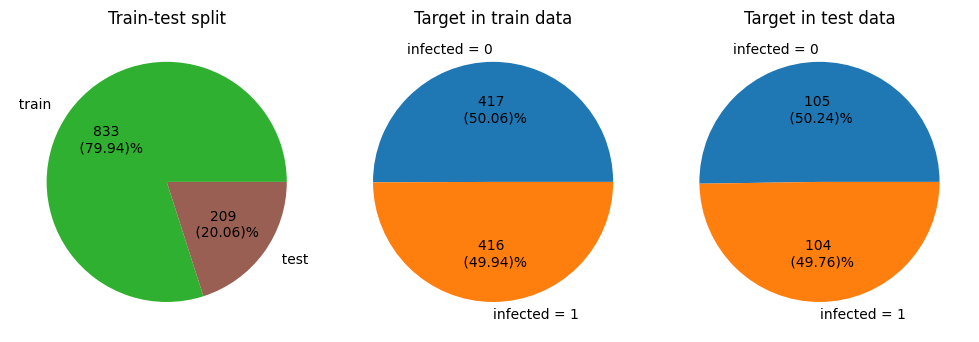

In [11]:
fig,ax = plt.subplots(1,3, figsize = (10,5))

print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:",y_test.shape)

# Train/test proportion

num_train = X_train.shape[0]
num_test = X_test.shape[0]
num_data = num_train + num_test
ax[0].pie([num_train,num_test],
        labels = ["  train  ", "  test  "],
        colors = [np.array(sns.color_palette()[2])*1.1,np.array(sns.color_palette()[5])*1.1],
        autopct= lambda p: f'{round(num_data * p / 100 )} \n ({round(100*p) /100})%') # to compute both the count and the percentage
ax[0].set_title(f"Train-test split")


# Target proportion n train and test

df_train = pd.concat([X_train, y_train], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)
for i,df in enumerate([df_train, df_test]):
        num_data = df.shape[0]
        text_data = ["train data", "test data"][i]
        ax[i+1].pie(df['infected'].value_counts(),
                labels = ["infected = 0", "infected = 1"], 
                colors = sns.color_palette(), 
                autopct= lambda p: f'{round(num_data * p / 100 )} \n ({round(100*p) /100})%') # to compute both the count and the percentage
        ax[i+1].set_title(f"Target in {text_data}")

plt.tight_layout()
plt.show()


## 030 boxplots for normalized variables +031 ##

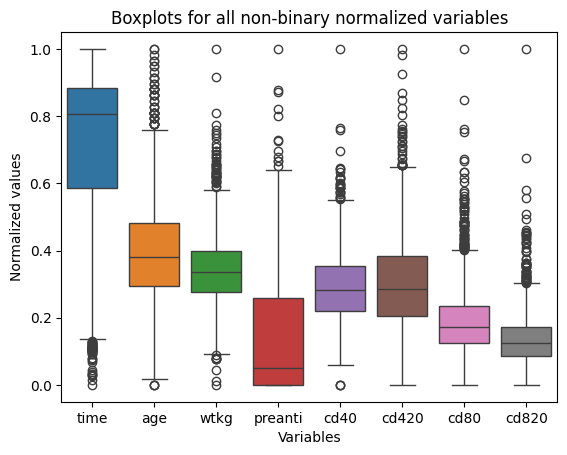

Outliers for preanti:

Below lower bound:
Empty DataFrame
Columns: [time, trt, age, wtkg, hemo, homo, drugs, karnof, oprior, z30, preanti, race, gender, str2, strat, symptom, treat, offtrt, cd40, cd420, cd80, cd820, infected]
Index: []

[0 rows x 23 columns]

Above upper bound:
      time  trt  age      wtkg  hemo  homo  drugs  karnof  oprior  z30  ...  \
292    314    0   54  68.49360     0     1      0      80       0    1  ...   
510   1186    1   38  78.92640     0     0      0      90       0    1  ...   
600   1139    1   30  66.80000     0     1      0      90       0    1  ...   
607    392    2   35  73.90000     0     1      0     100       0    1  ...   
806    312    1   42  76.10000     0     1      0      90       0    1  ...   
1289  1021    0   36  56.24640     0     1      1      90       0    1  ...   
1365   236    2   41  98.43120     0     1      0      90       0    1  ...   
1377   959    3   42  58.00000     0     1      0     100       0    1  ...   
1695   549

In [ ]:
data = pd.read_csv("./data/AIDS_Classification.csv")
non_binary_data = data.loc[:, data.nunique() > 4]
scaler = MinMaxScaler()
non_binary_scaled = scaler.fit_transform(non_binary_data)
non_binary_scaled_df = pd.DataFrame(non_binary_scaled, columns=non_binary_data.columns)

sns.boxplot(data=non_binary_scaled_df)
plt.title('Boxplots for all non-binary normalized variables')
plt.xlabel('Variables')
plt.ylabel('Normalized values')
plt.show()

outliers = {}

for col in ['preanti', 'cd40', 'cd420', 'cd80', 'cd820']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers[col] = {
        'below': data[data[col] < lower_bound],
        'above': data[data[col] > upper_bound]
    }
    print(f"Outliers for {col}:\n")
    print(f"Below lower bound:\n{outliers[col]['below']}\n")
    print(f"Above upper bound:\n{outliers[col]['above']}\n")

## 032 ##

## 035 SKB Evaluation loop

###

### Validation with K Fold Cross Validation


In [26]:
def validation_accuracy_score(Xtrain,ytrain,model, n_splits = 5):
    # Create the K-Fold cross-validator
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation measuring the Accuracy
    scores = cross_val_score(
        model, Xtrain, ytrain, cv=cv, scoring='accuracy', n_jobs=-1
    )

    # Calculate the mean of the MSE scores
    mean_accuracy = scores.mean() 
    return mean_accuracy

### Feature Selection with Select K Best


In [ ]:
# SELECT K-BEST
def skb_select_features(X, y, k):
    skb = SelectKBest(score_func=f_classif, k = k)
    skb = skb.fit(X, y)
    selected_features = X.columns[skb.get_support(indices=True)]
    return selected_features

In [39]:
X = X_train
y = y_train
max_k = len(X.columns)

results_skb = []
for k in range(1,max_k+1):
    skb_features = skb_select_features(X,y,k)
    model = LogisticRegression()
    score = validation_accuracy_score(X[skb_features],y,model,n_splits = 5)
    results_skb.append({"k": k, "score": round(score,4), "features":list(skb_features)})
results_skb_df = pd.DataFrame(results_skb)
results_skb_df

,k,score,features
0,1,0.7960,[time]
1,2,0.8128,"[time, cd420]"
2,3,0.8211,"[time, cd40, cd420]"
3,4,0.8211,"[time, symptom, cd40, cd420]"
4,5,0.8247,"[time, symptom, treat, cd40, cd420]"
5,6,0.8199,"[time, karnof, symptom, treat, cd40, cd420]"
6,7,0.8187,"[time, karnof, preanti, symptom, treat, cd40, ..."
7,8,0.8139,"[time, karnof, preanti, strat, symptom, treat,..."
8,9,0.8247,"[time, karnof, z30, preanti, strat, symptom, t..."
9,10,0.8115,"[time, trt, karnof, z30, preanti, strat, sympt..."


### 036 Plot SKB vs accuracy

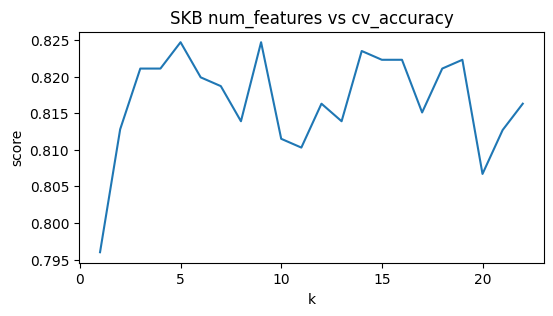

In [40]:
sns.lineplot(data = results_skb_df, x = "k", y = "score")
plt.title("SKB num_features vs cv_accuracy")
plt.show()

## 037 Select k for SKB

We will choose k=5, which gives a 5-fold cv accuracy score 0.8247

In [30]:
skb_best_features = "time, symptom, treat, cd40, cd420".split()